In [1]:
import numpy as np
import torch
from torch import nn  
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn'
# path.insert(1,  root+'/work')

In [3]:
from get_data_lw_AM4_std import get_data_lw_AM4
######################################################
# common functions to split the training and test data

from NNRTMC_utils import NNRTMC_NN_lw, split_train_test_sample, \
draw_batches, data_std_normalization_lw, return_exp_dir
torch.set_float32_matmul_precision('high')

from diag_utils import batch_index_sta_end, pred_NN_batch,\
create_6tiles_lw_v2,regrid_6tile2latlon

In [4]:
plt.rcParams['font.size'] = '6'

In [5]:
# torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
# device = f'cuda:{torch.cuda.current_device()}'
device = 'cpu'
######################################################
# set exp name and runs
Exp_name = [
    'ens_AM4std_lw_cs_LiH4W256Relu_EY_D211'    ,
    'ens_AM4std_lw_all_LiH4W256Relu_EY_D211'   ,
    'ens_AM4std_lw_cs_LiH4W256Relu_EN_D211'    ,
    'ens_AM4std_lw_all_LiH4W256Relu_EN_D211'   ,
] 
sky_cond = {
    'ens_AM4std_lw_cs_LiH4W256Relu_EY_D211'    : 'cs',
    'ens_AM4std_lw_all_LiH4W256Relu_EY_D211'   : 'all',
    'ens_AM4std_lw_cs_LiH4W256Relu_EN_D211'    : 'cs',
    'ens_AM4std_lw_all_LiH4W256Relu_EN_D211'   : 'all',
}
work_dir = root+'/work/' 
# file list AM4 runs 
filelist = [f'/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/'+
            f'HISTORY/20000101.atmos_8xdaily.tile{_}.nc' for _ in range(1,7)] 
hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values[None,:]
B_k = hybrid_p_sigma_para.bk.values[None,:] 

In [6]:
month_sel = None 
day_sel = [2,11]

# Plot Loss

In [7]:
ensemble_size = 3
loss_array = {}
for mo in Exp_name:
    loss_array[mo] = []
    for ei in range(ensemble_size):
        ######################################################
        # load restart file
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        # load restart file
        PATH_last =  exp_dir+f'/model{ei}_restart.{run_num-1:02d}.pth'
        restart_data = torch.load(PATH_last)  # load exist results and restart training
        print(f'load: {PATH_last}')
        # read training dataset, nor_para, model parameteres
        loss_array[mo].append(restart_data['loss_array'])

load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/model0_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/model1_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/model2_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/model0_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/model1_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/model2_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/model0_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/model1_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/model2_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256R

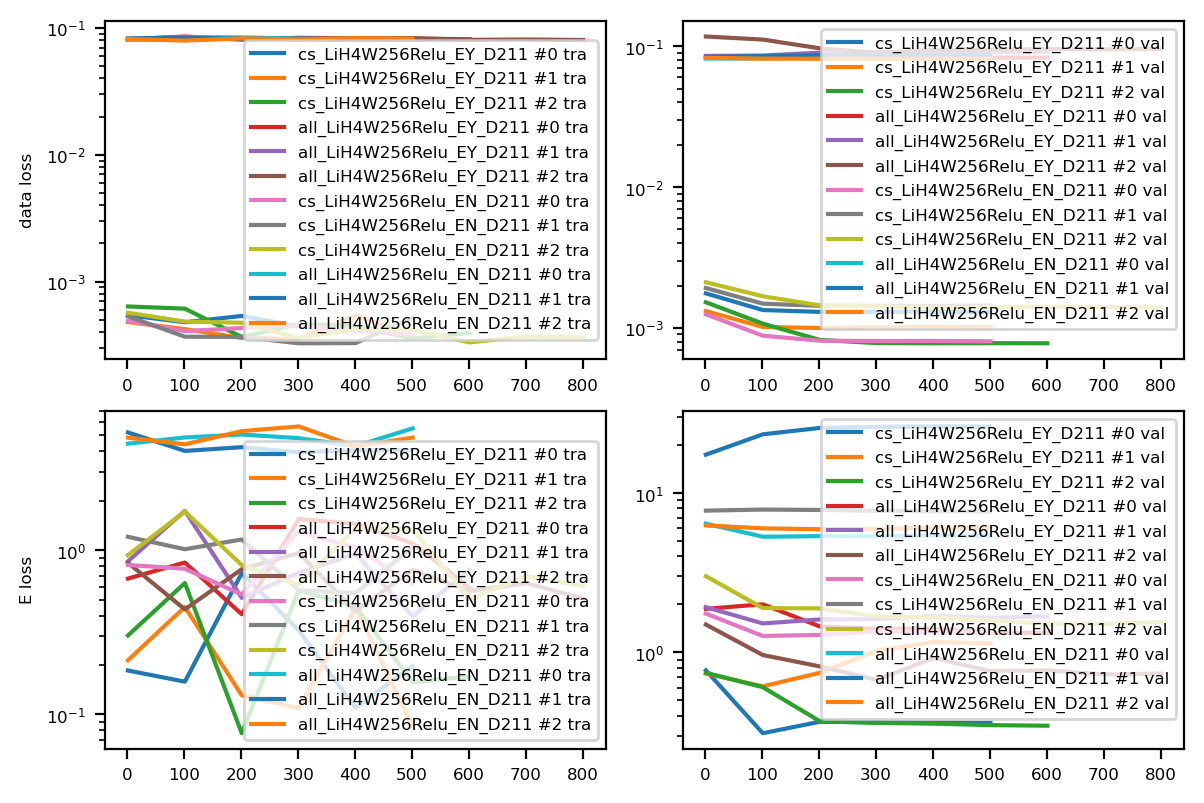

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,4),dpi=200, tight_layout=True)  
axs = axs.flatten()
for mo in Exp_name:
    for ei in range(ensemble_size):
        epochs  = loss_array[mo][ei][0]
        LD_tra  = loss_array[mo][ei][1]
        LE_tra  = loss_array[mo][ei][2]
        LD_val  = loss_array[mo][ei][3]
        LE_val  = loss_array[mo][ei][4]
        axs[0].plot(epochs,LD_tra, label = f'{mo[14:]} #{ei} tra')
        axs[1].plot(epochs,LD_val, label = f'{mo[14:]} #{ei} val')
        axs[2].plot(epochs,LE_tra, label = f'{mo[14:]} #{ei} tra')
        axs[3].plot(epochs,LE_val, label = f'{mo[14:]} #{ei} val')
for ax in axs:
    ax.set_yscale('log')
    ax.legend()
axs[0].set_ylabel('data loss')
axs[2].set_ylabel('E loss')
fig.show()

In [9]:
for mo in Exp_name:
    for ei in range(ensemble_size):
        epochs  = loss_array[mo][ei][0]
        LD_tra  = loss_array[mo][ei][1]
        LE_tra  = loss_array[mo][ei][2]
        LD_val  = loss_array[mo][ei][3]
        LE_val  = loss_array[mo][ei][4]
        print(mo)
        for epi,ep in enumerate(epochs):
            print(f'{ep:4.0f} tra {LD_tra[epi]:8.2e} {LE_tra[epi]:8.2e} val {LD_val[epi]:8.2e} {LE_val[epi]:8.2e} ')

ens_AM4std_lw_cs_LiH4W256Relu_EY_D211
   1 tra 5.43e-04 1.85e-01 val 1.76e-03 7.71e-01 
 101 tra 4.78e-04 1.58e-01 val 1.34e-03 3.11e-01 
 201 tra 5.36e-04 7.25e-01 val 1.30e-03 3.67e-01 
 301 tra 4.43e-04 3.25e-01 val 1.30e-03 3.64e-01 
 401 tra 4.12e-04 1.10e-01 val 1.30e-03 3.62e-01 
 501 tra 4.12e-04 1.97e-01 val 1.30e-03 3.60e-01 
ens_AM4std_lw_cs_LiH4W256Relu_EY_D211
   1 tra 4.80e-04 2.14e-01 val 1.32e-03 7.36e-01 
 101 tra 4.22e-04 4.51e-01 val 1.02e-03 6.12e-01 
 201 tra 3.59e-04 1.31e-01 val 9.99e-04 7.44e-01 
 301 tra 3.53e-04 1.09e-01 val 1.01e-03 1.02e+00 
 401 tra 5.40e-04 4.48e-01 val 1.02e-03 1.16e+00 
 501 tra 3.72e-04 8.50e-02 val 1.01e-03 1.14e+00 
ens_AM4std_lw_cs_LiH4W256Relu_EY_D211
   1 tra 6.37e-04 3.02e-01 val 1.52e-03 7.45e-01 
 101 tra 6.12e-04 6.31e-01 val 1.07e-03 6.04e-01 
 201 tra 3.66e-04 7.68e-02 val 8.22e-04 3.70e-01 
 301 tra 4.63e-04 5.70e-01 val 7.80e-04 3.61e-01 
 401 tra 4.43e-04 4.54e-01 val 7.78e-04 3.57e-01 
 501 tra 3.57e-04 1.57e-01 val 7.79e

## load model

In [10]:
NN_model = {} 

for mo in Exp_name:
    NN_model[mo] = []
    for ei in range(ensemble_size):
        ######################################################
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        # load restart file
        PATH_last =  exp_dir+f'/model{ei}_restart.{run_num-1:02d}.pth'
        restart_data = torch.load(PATH_last)  # load exist results and restart training
        print(f'load: {PATH_last}')
        # read training dataset, nor_para, model parameteres
        nor_para = restart_data['nor_para']
        model_state_dict = restart_data['model_state_dict']
        nn_struc_name = list(restart_data['model_state_dict'].keys())
        input_size  = restart_data['model_state_dict'][nn_struc_name[0]].shape[1]
        output_size = restart_data['model_state_dict'][nn_struc_name[-1]].shape[0]
        hidden_layer_width = restart_data['model_state_dict'][nn_struc_name[0]].shape[0]
        print(input_size, output_size, hidden_layer_width,) 
        # initialize model 
        nn_model_ei = NNRTMC_NN_lw(device, nor_para, A_k, B_k, input_size, output_size, hidden_layer_width, model_state_dict)  
        NN_model[mo].append(nn_model_ei)

load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/model0_restart.03.pth
101 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/model1_restart.03.pth
101 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/model2_restart.03.pth
101 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/model0_restart.03.pth
365 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/model1_restart.03.pth
365 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/model2_restart.03.pth
365 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/model0_restart.03.pth
101 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/model1_restart.03.pth
101 35 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/mode

In [11]:
%%time  
recalculate = False
# recalculate = True
ds_regrid = {} 

for mo in Exp_name: 
    ds_regrid[mo] = [] 
    if (recalculate == True) :
    # read data
        input_array_ori, output_array_ori, ds_coords = \
        get_data_lw_AM4(filelist, condition=sky_cond[mo], 
                        month_sel = month_sel, day_sel = day_sel, return_coords=True)  
    for ei in range(ensemble_size):
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        NN_output_name = f'NN_{ei}_20000101.fluxes' 
        if (recalculate == True) :
        # pred with NN and regrid to lat lon grid.
            nor_para = NN_model[mo][ei].nor_para
            nor_para = {key: value.to('cpu').numpy() for key, value in nor_para.items()} 
            # normalize data via saved nor_para in restart file
            nor_para, input_array, output_array   = data_std_normalization_lw(input_array_ori, output_array_ori, nor_para)

            # try NN on test dataset  
            predi, eng_err = pred_NN_batch(input_array, output_array, NN_model[mo][ei], nor_para, device)
            error = predi - output_array_ori
            predi[:,2:] = predi[:,2:]*86400 # HR K/s >> K/day
            error[:,2:] = error[:,2:]*86400 # HR K/s >> K/day 
            # create 6-tile files for output and regrid 
            subprocess.run([f'mkdir -p {exp_dir}/NN_pred'], shell=True, check=True)
            var_list = create_6tiles_lw_v2(ds_coords, predi, error, eng_err,  exp_dir, NN_output_name)
            del predi, error, eng_err
            regrid_file_path = regrid_6tile2latlon(var_list,exp_dir,root, NN_output_name)
        regrid_file_path = exp_dir+f'/NN_pred/{NN_output_name}.nc'
        print(regrid_file_path)
        # open regridded file
        with  xr.open_dataset(regrid_file_path) as ds:
            ds_regrid[mo].append(ds.load().rename({'grid_yt':'lat', 'grid_xt':'lon'}))


/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_1_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_2_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/NN_pred/NN_1_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_all_LiH4W256Relu_EY_D211/NN_pred/NN_2_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/NN_pred/NN_0_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/NN_pred/NN_1_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EN_D211/NN_pred/NN_2_20000101.fluxes.nc
/tigress/cw55/work/2022_radi_nn/wo

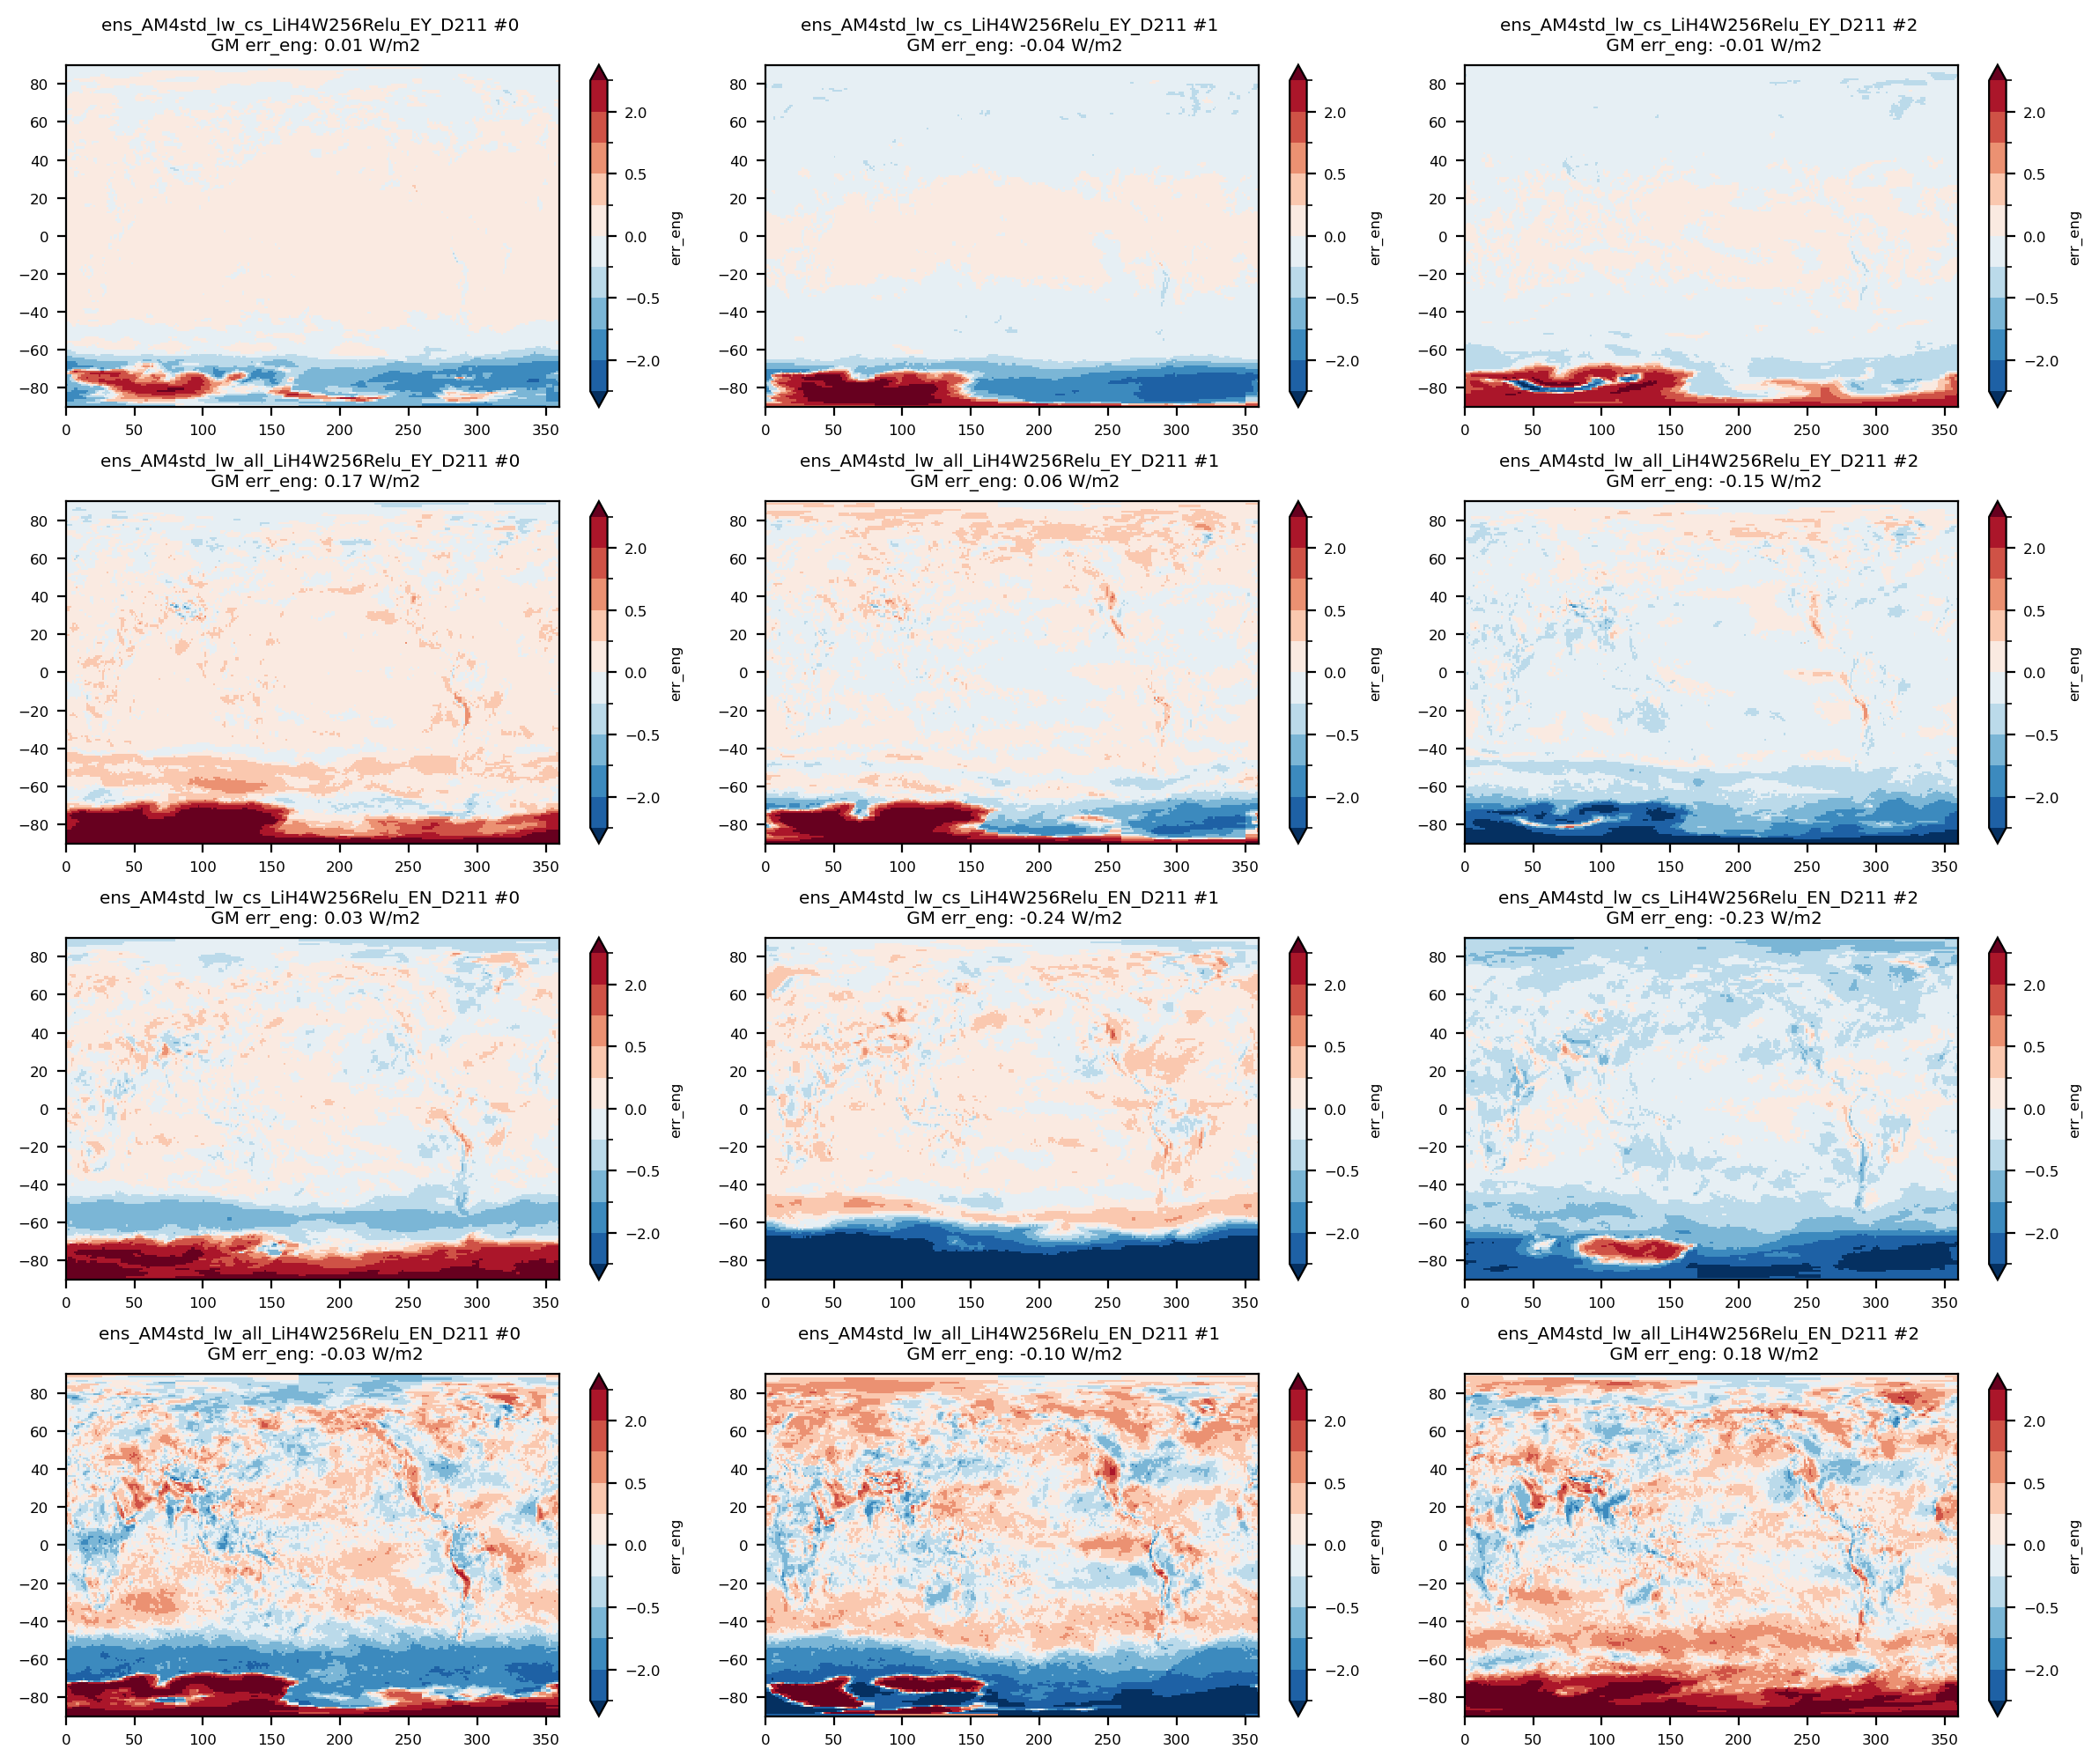

In [12]:
fig, axs = plt.subplots(nrows=len(Exp_name),ncols=ensemble_size,figsize=(4*ensemble_size,2.5*(len(Exp_name))),dpi=200)
axs = axs.flatten() 
for i, mo in enumerate(Exp_name):
    for ei in range(ensemble_size):
        ds_plot = ds_regrid[mo][ei]
        var_name = 'err_eng'
        level = np.array([-4,-2,-1,-0.5,-0.2, 0, 0.2, 0.5, 1, 2, 4])
        # level = np.arange(-5,5.1,0.5)
        # if sky_cond[mo] == 'all':  level = level*2
        ax=axs[i*ensemble_size+ei]
        da = ds_plot[var_name].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'{mo} #{ei} \n GM err_eng: {global_mean_xarray(da).values:4.2f} W/m2') 
        ax.set(xlabel=None,ylabel=None) 
fig.tight_layout()

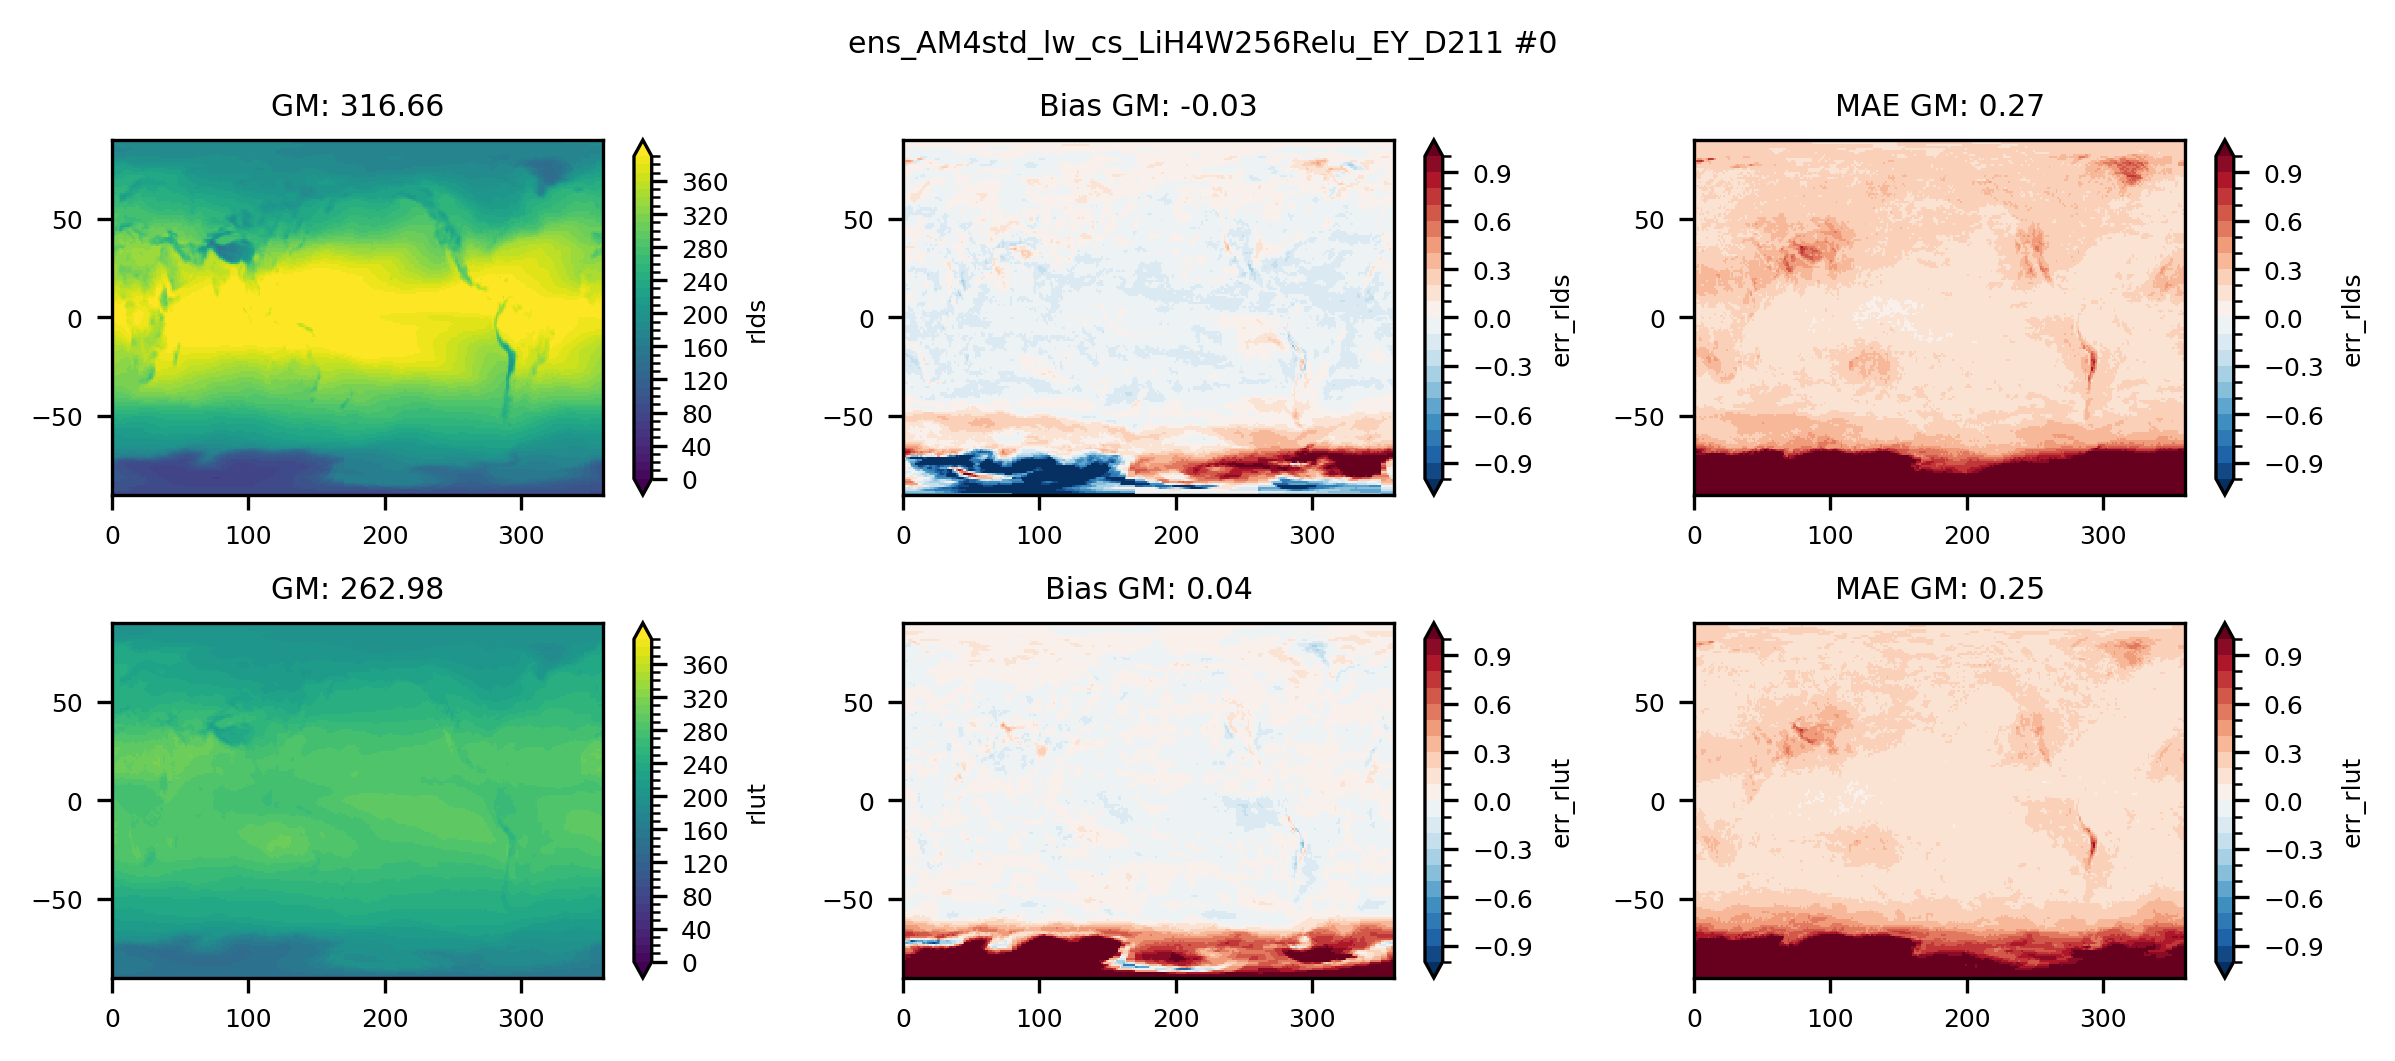

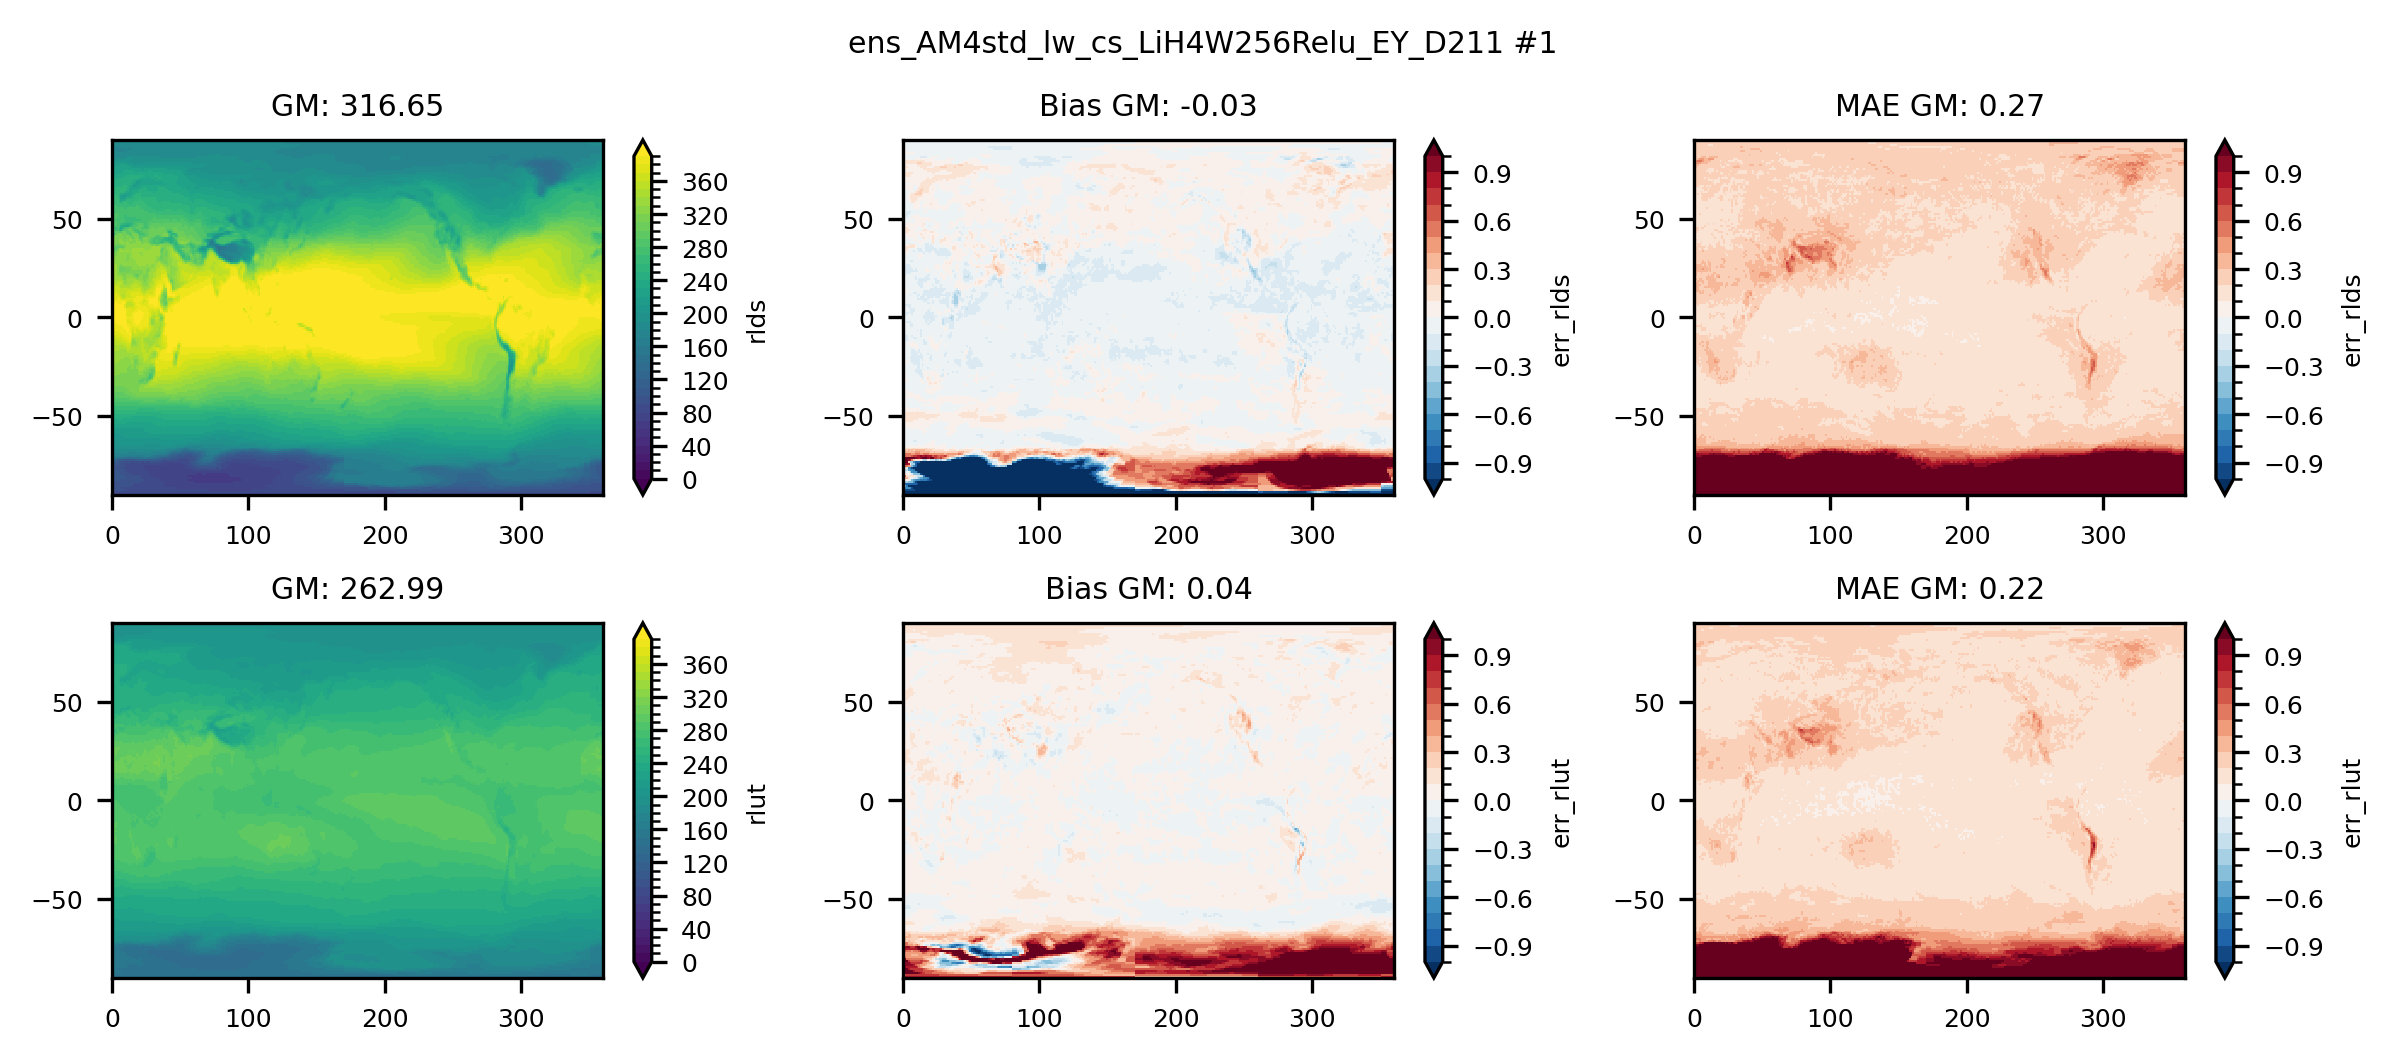

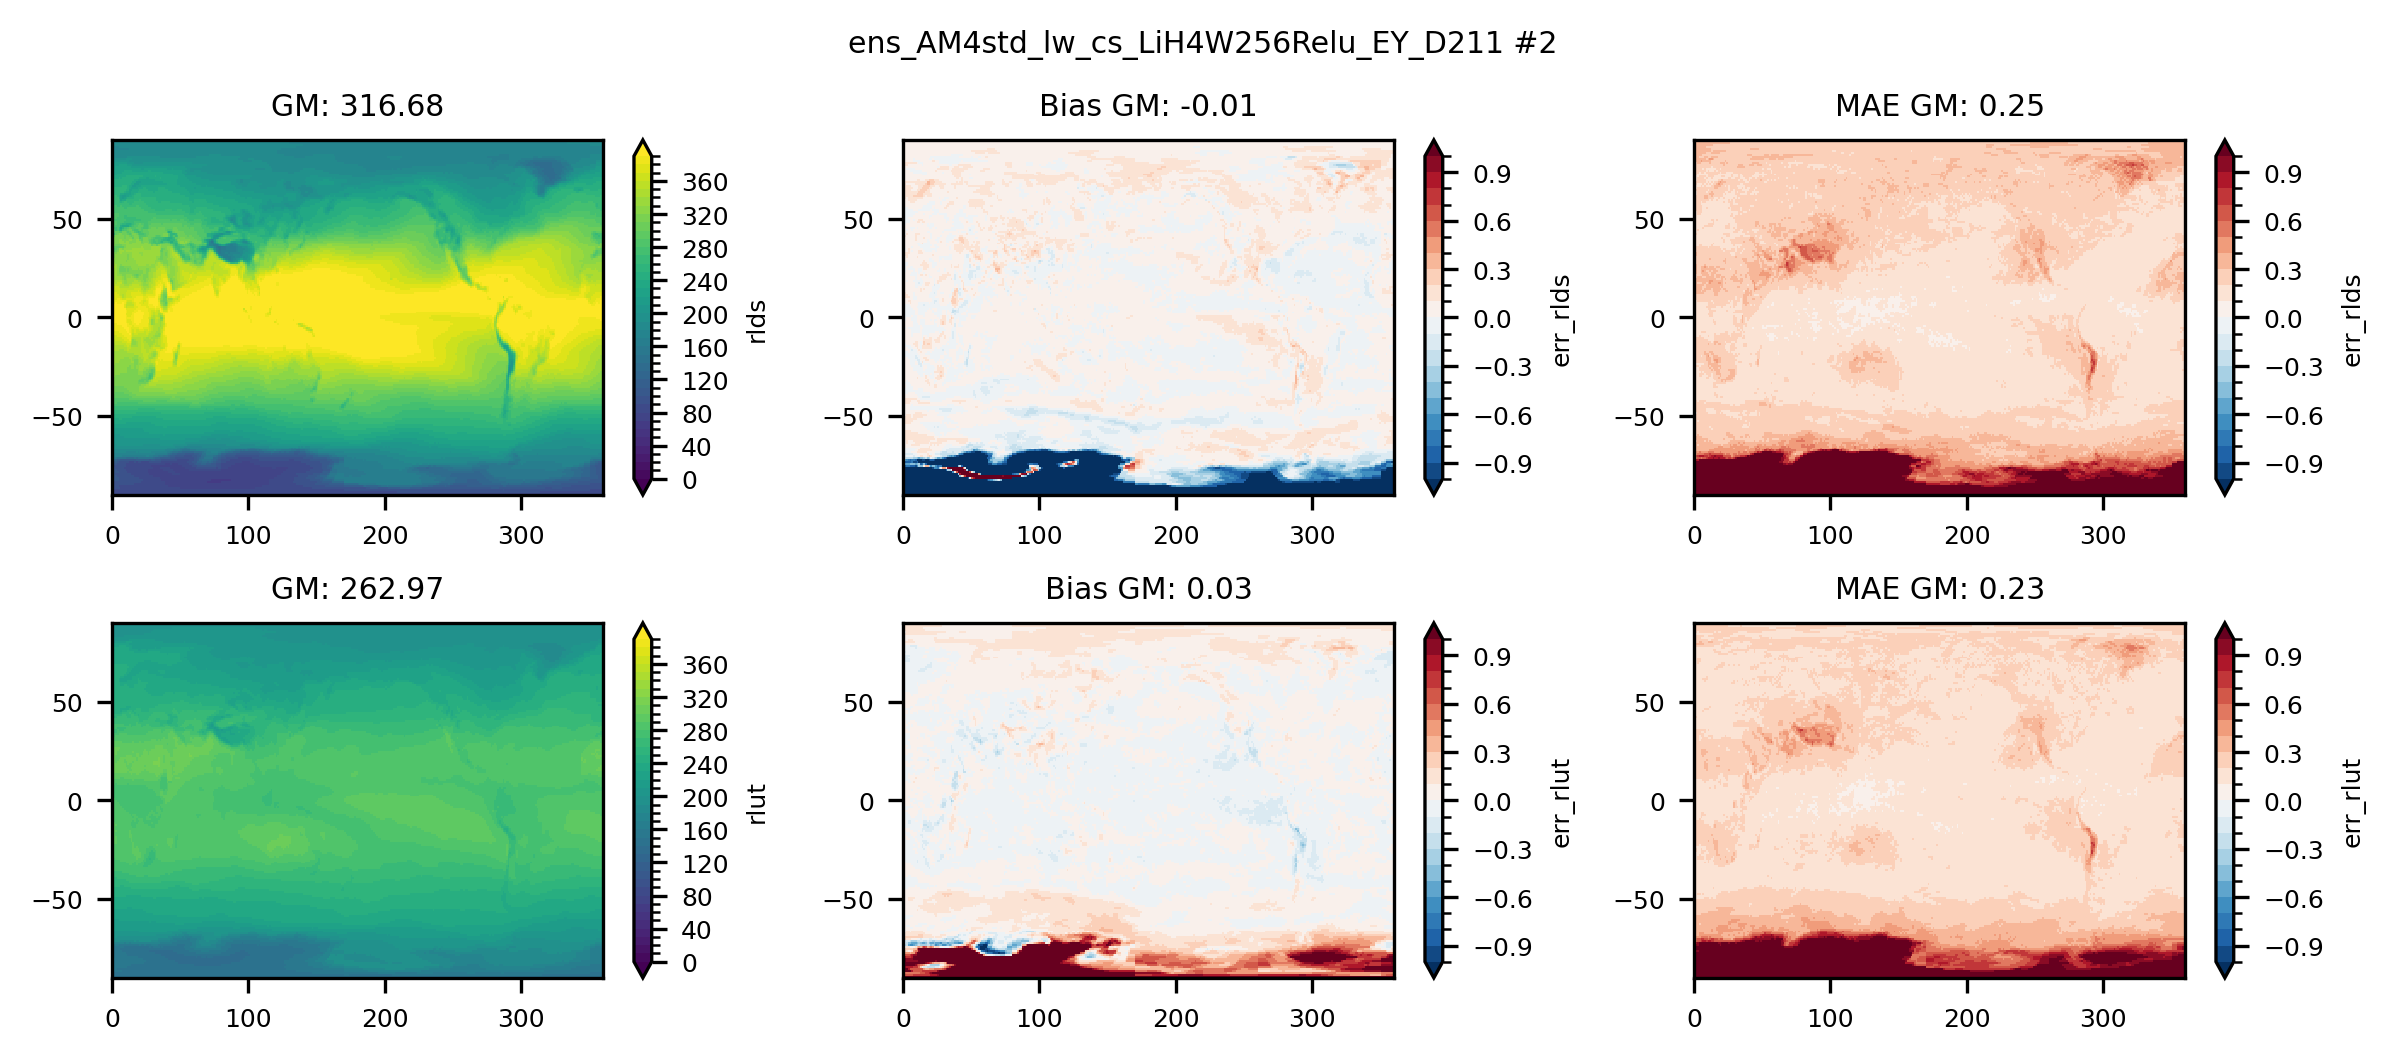

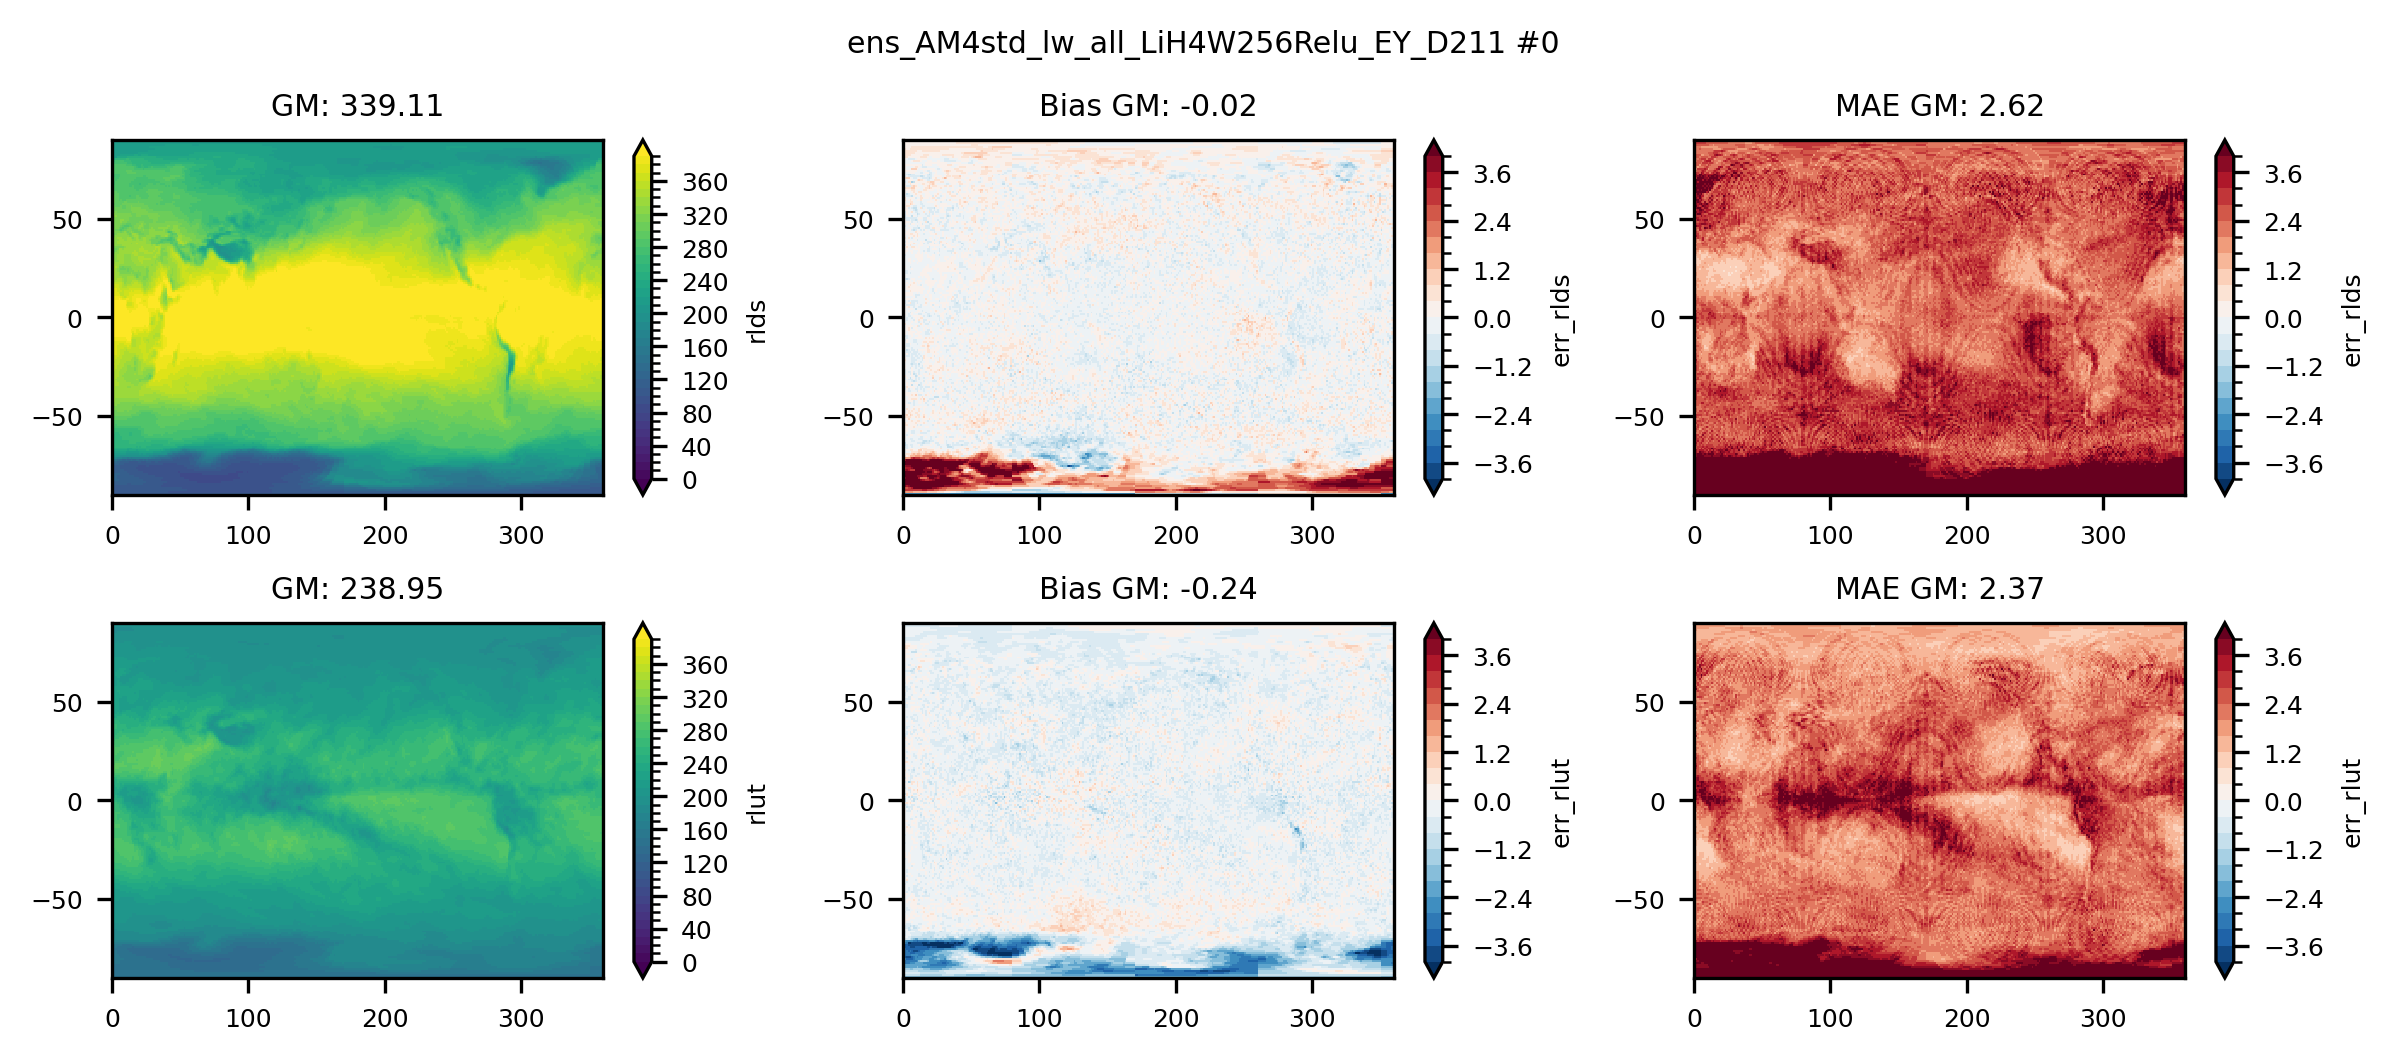

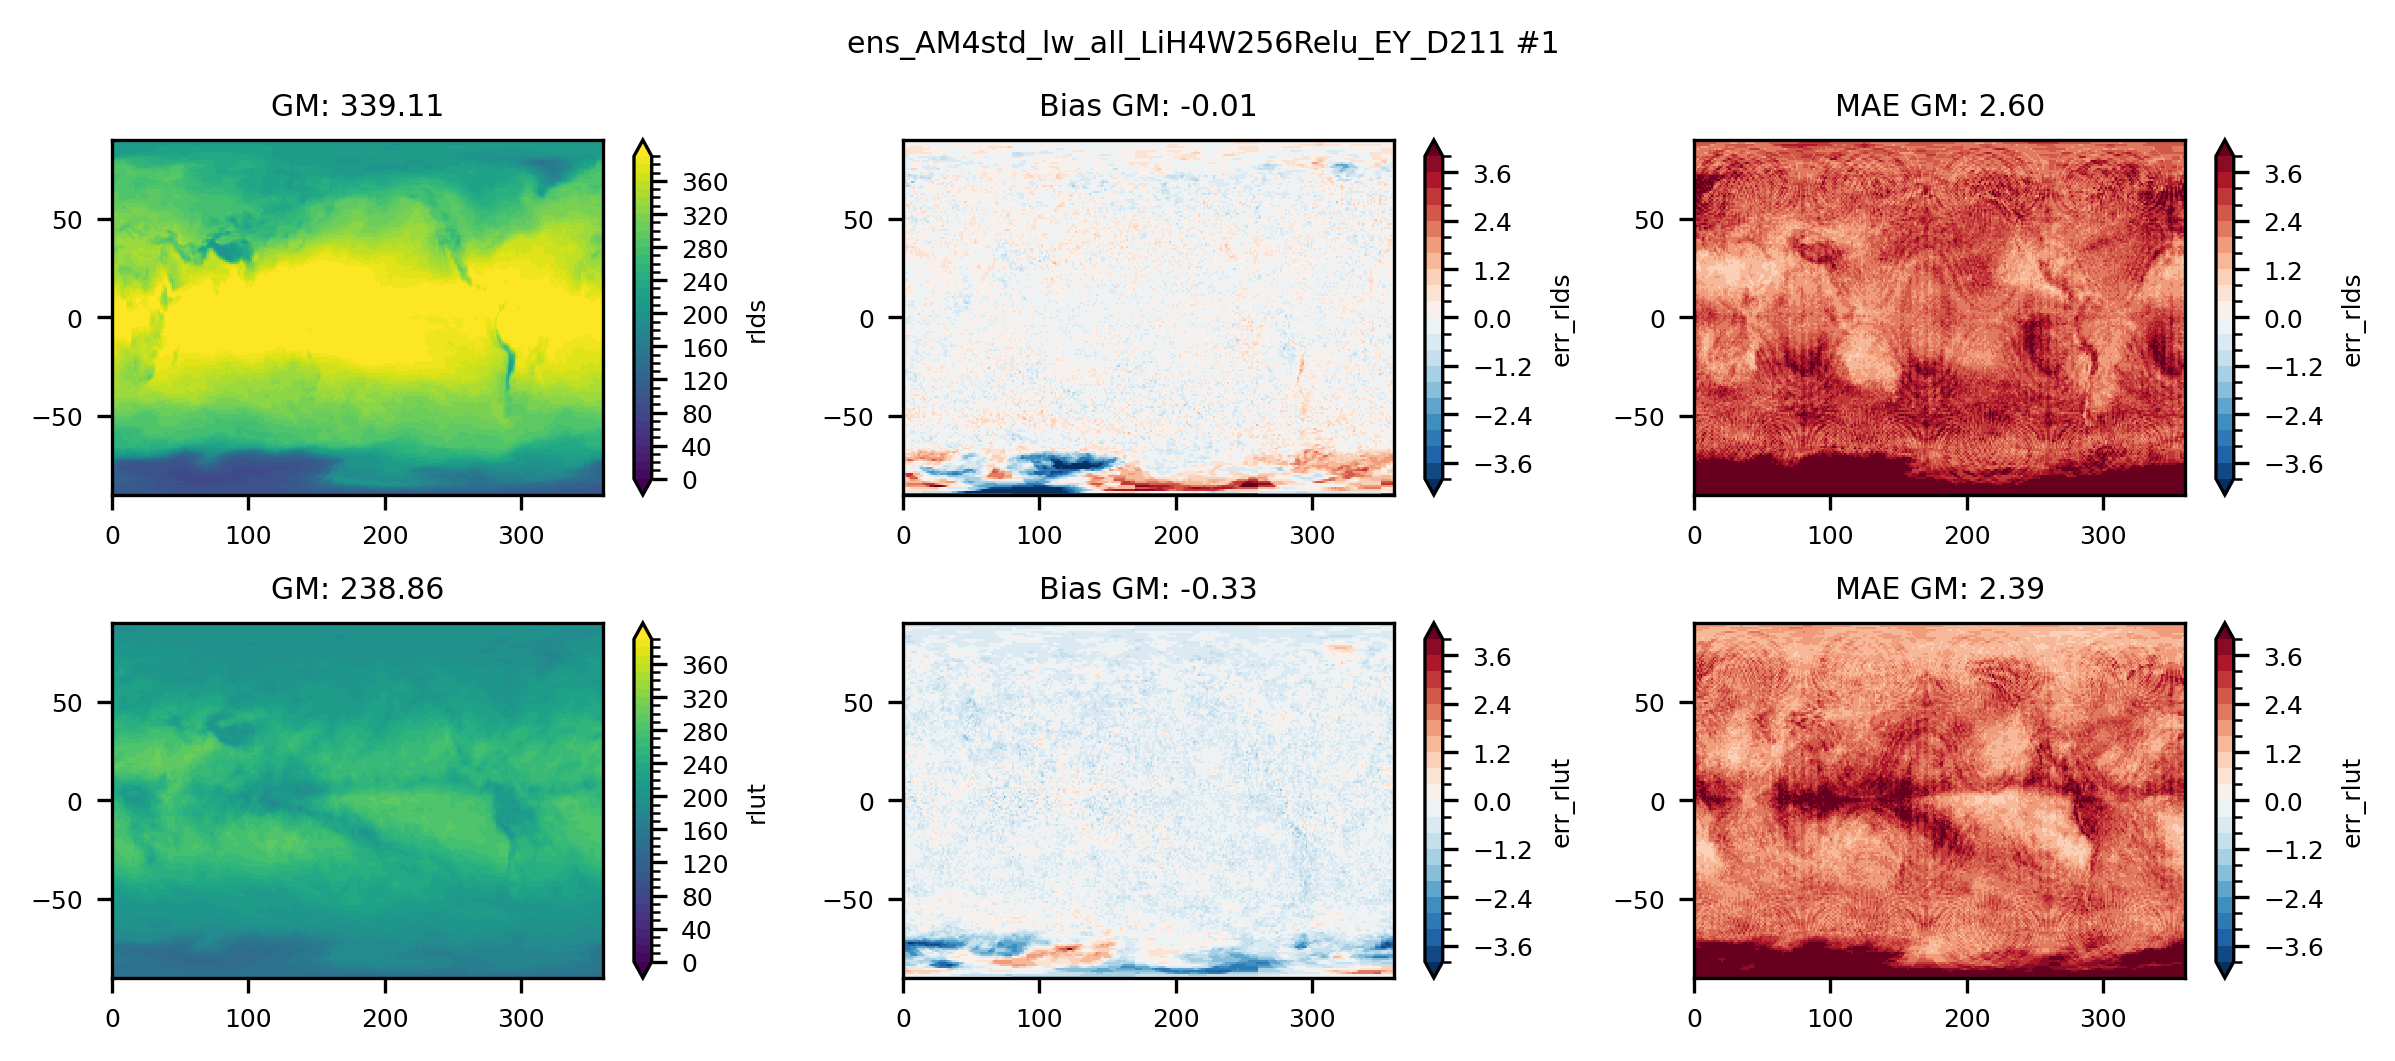

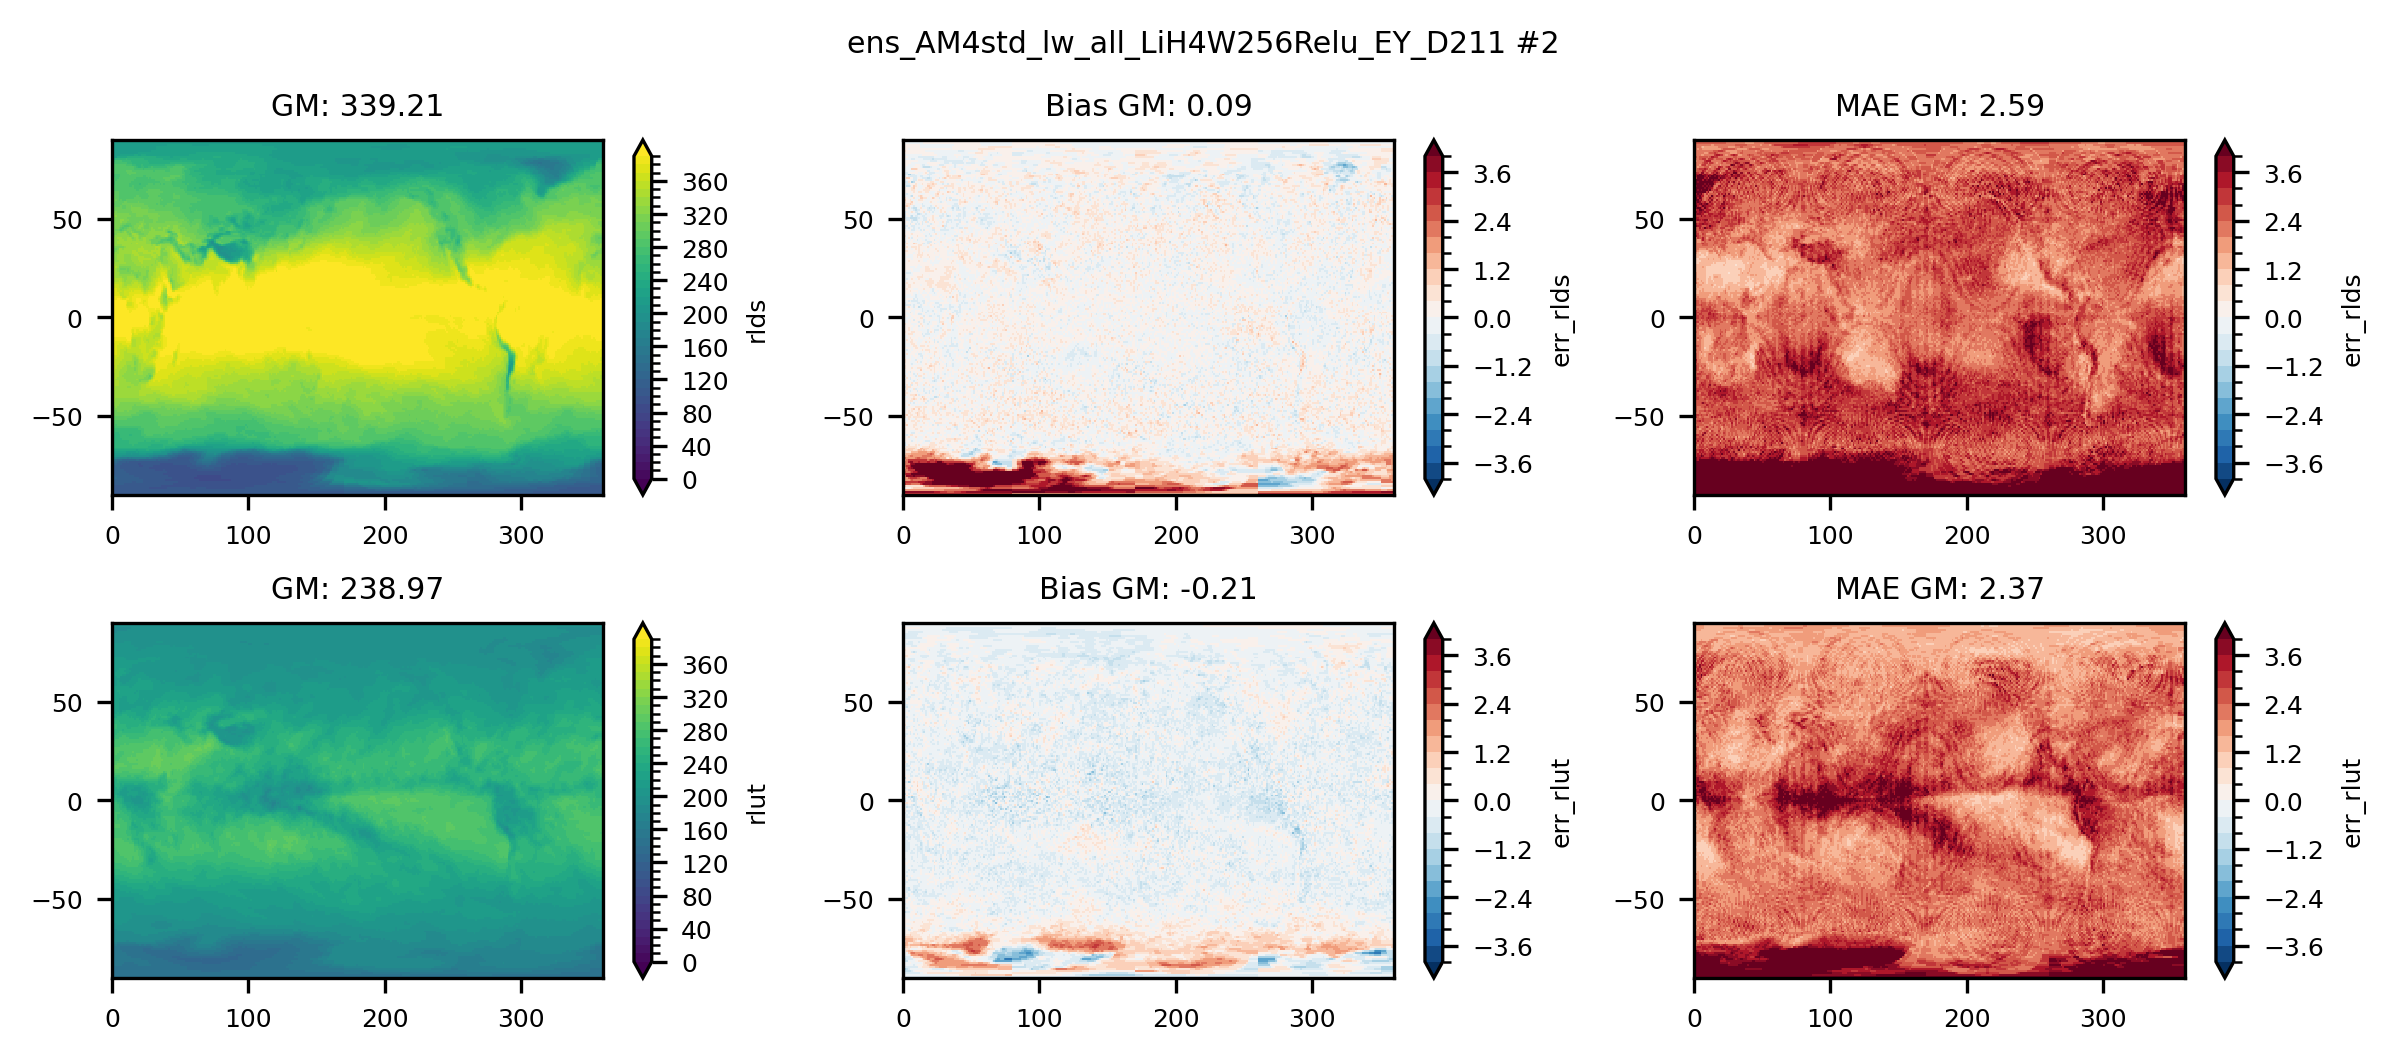

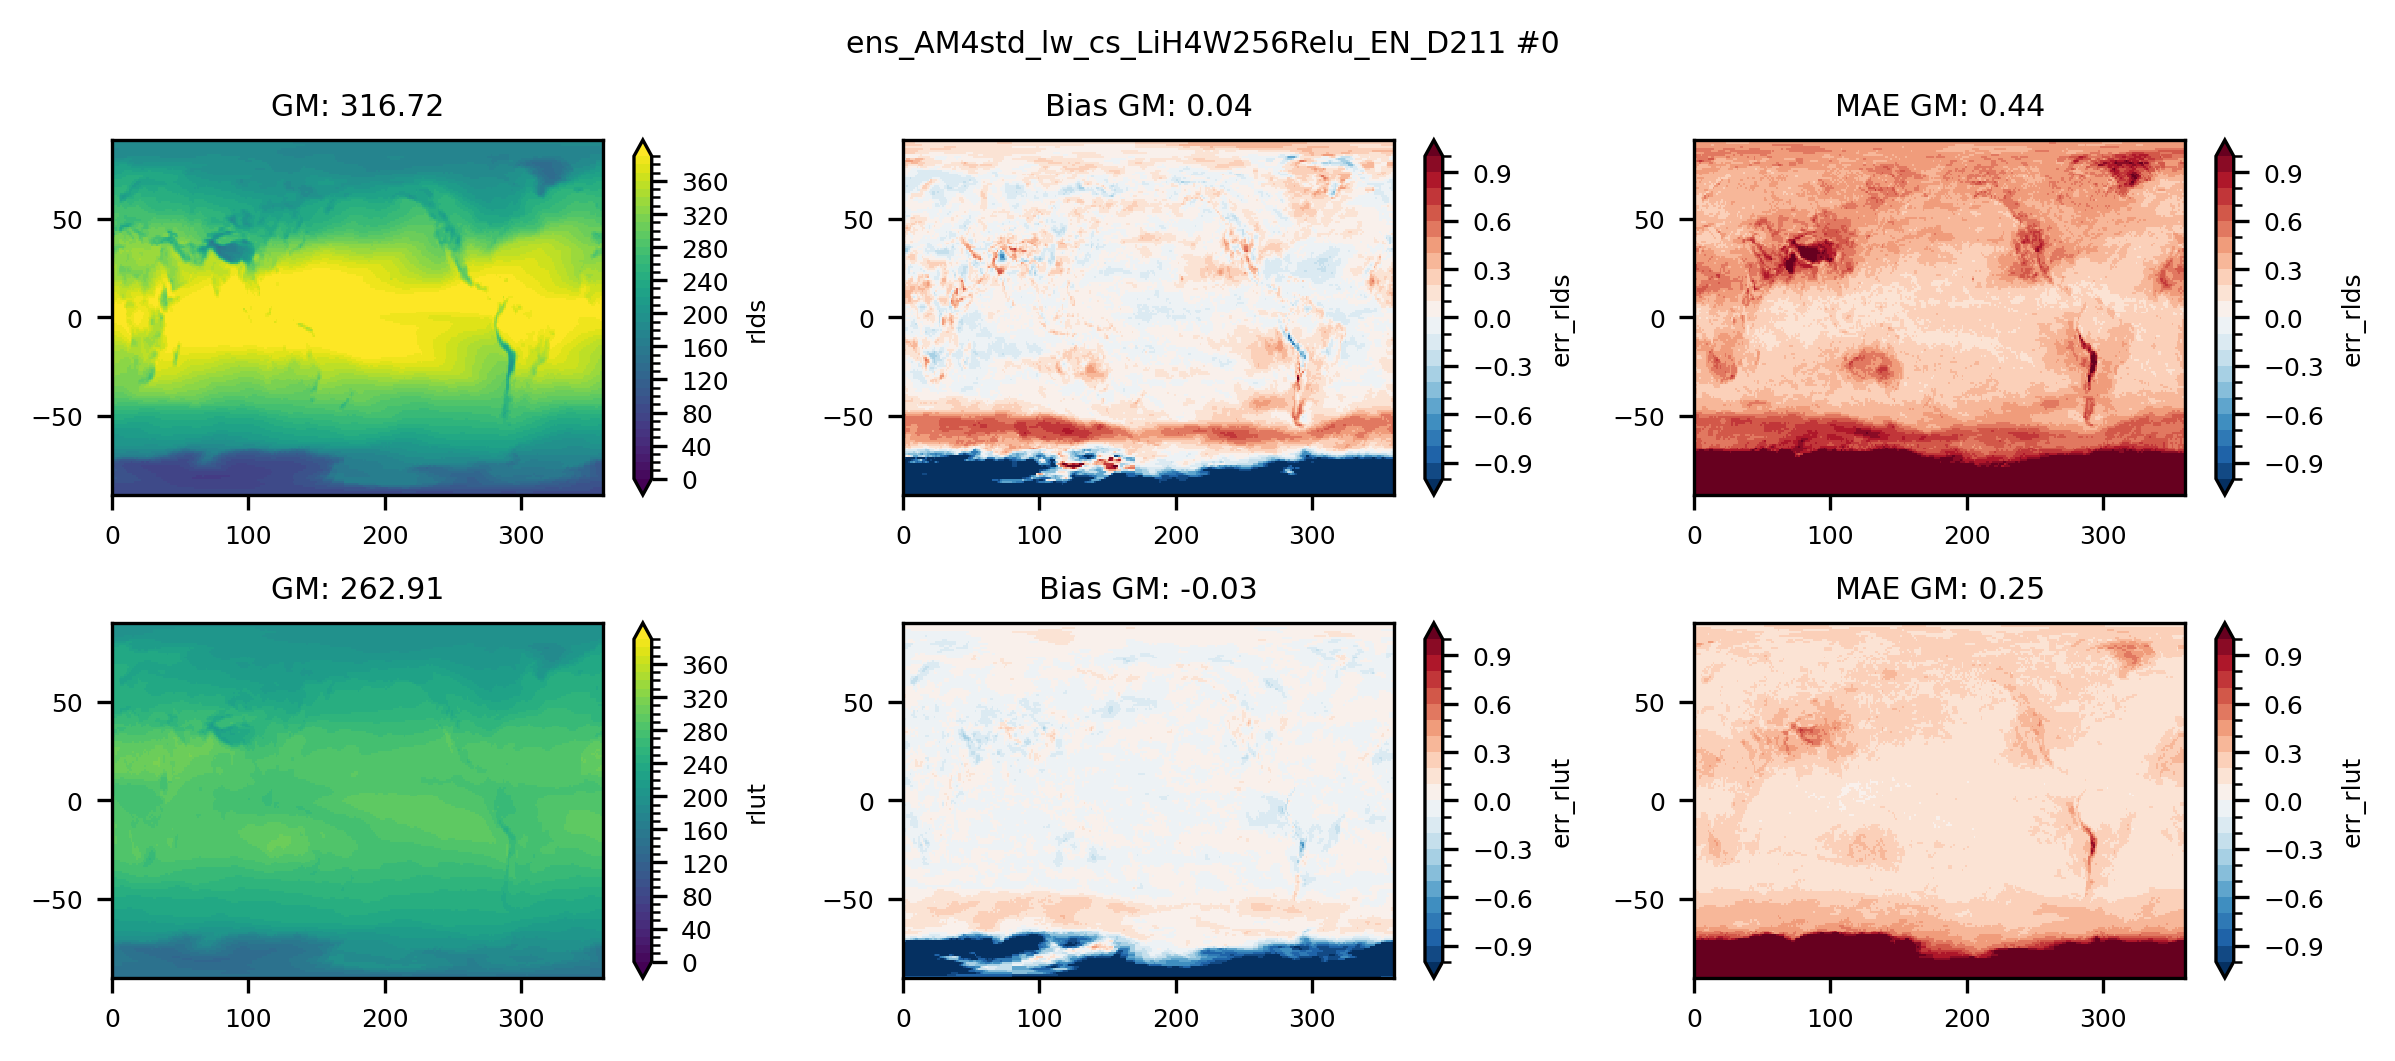

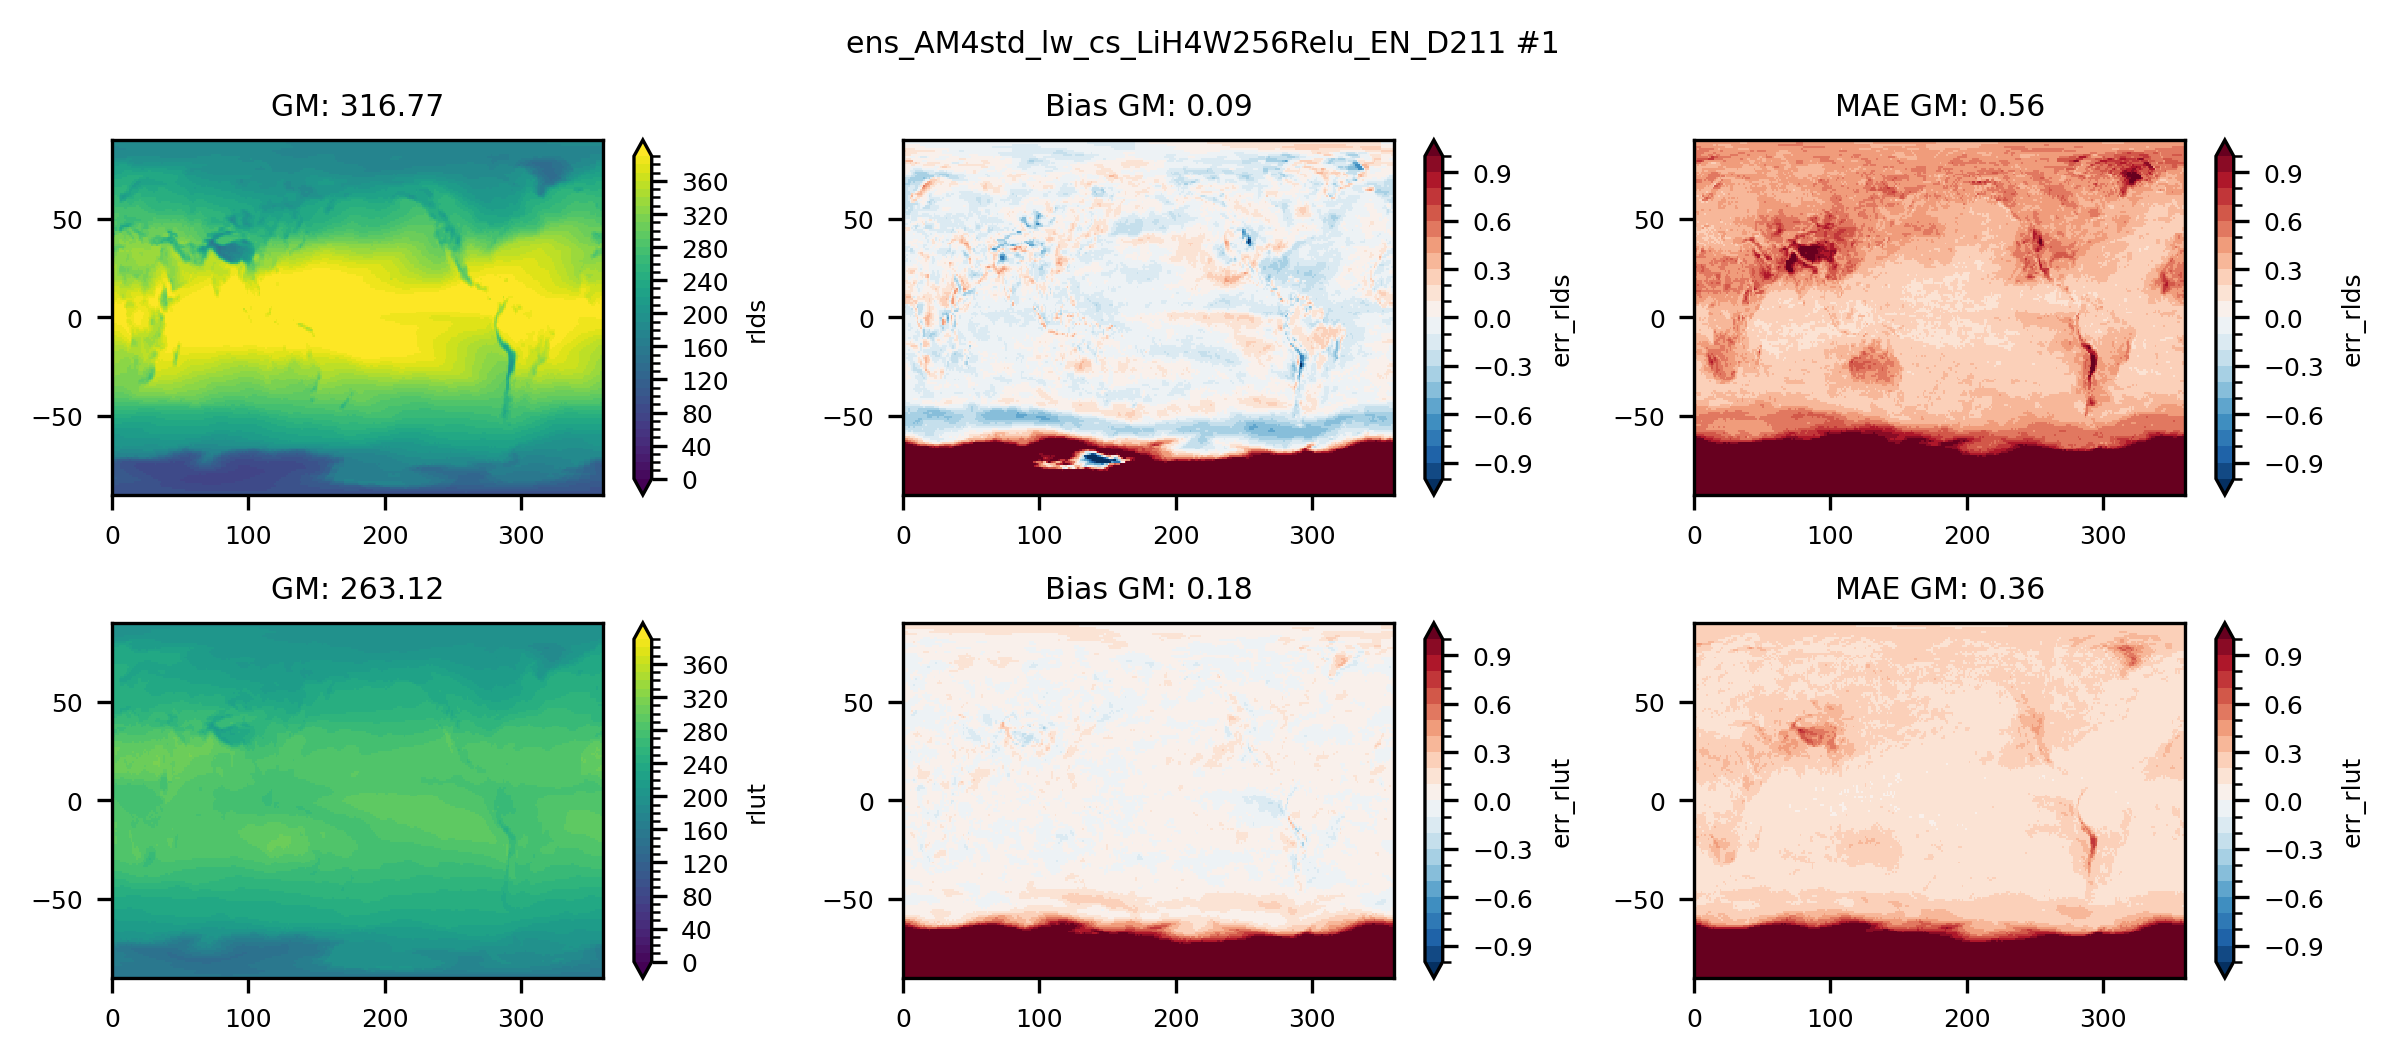

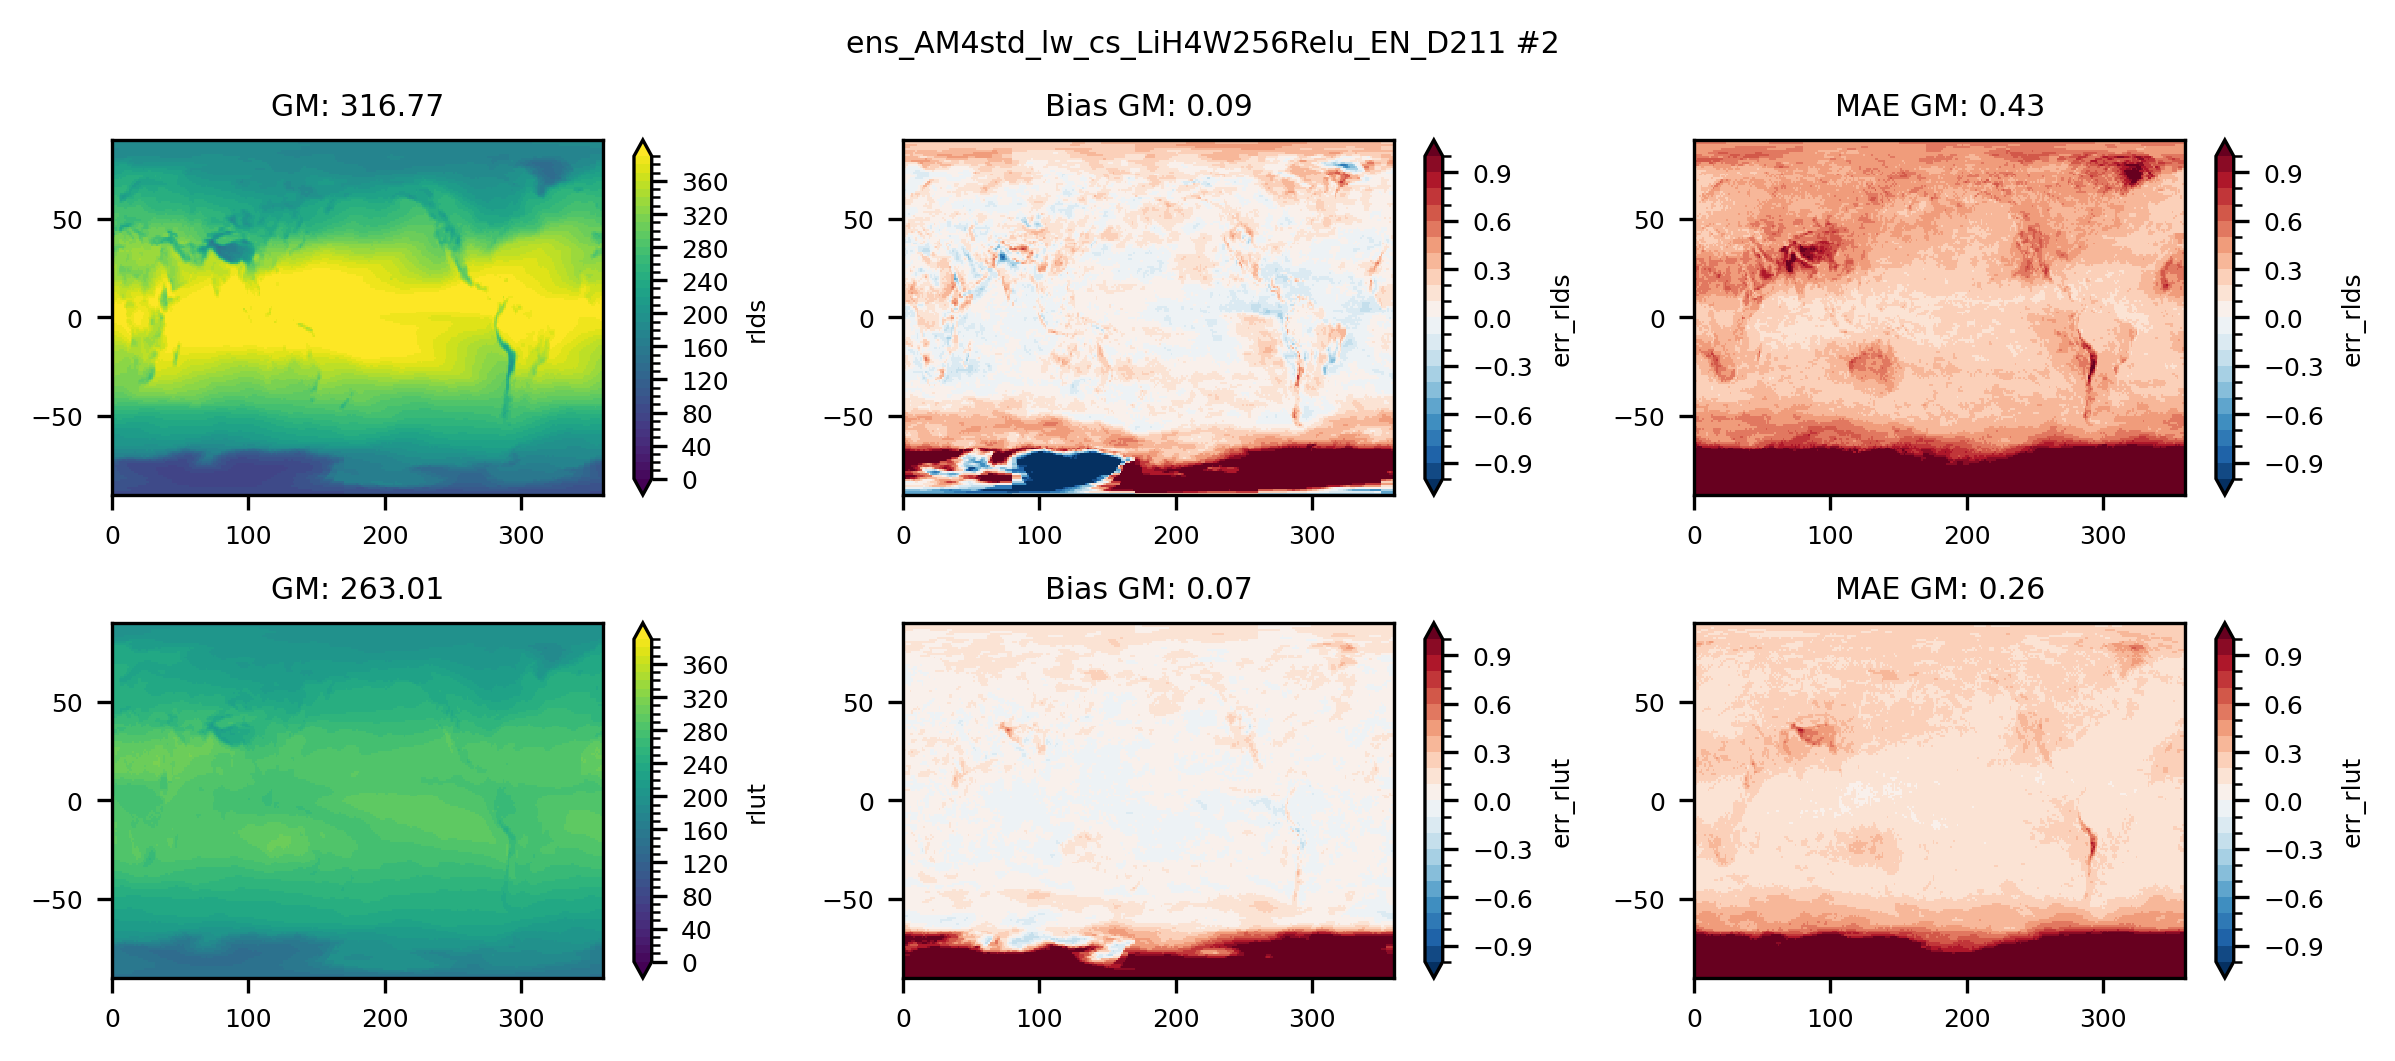

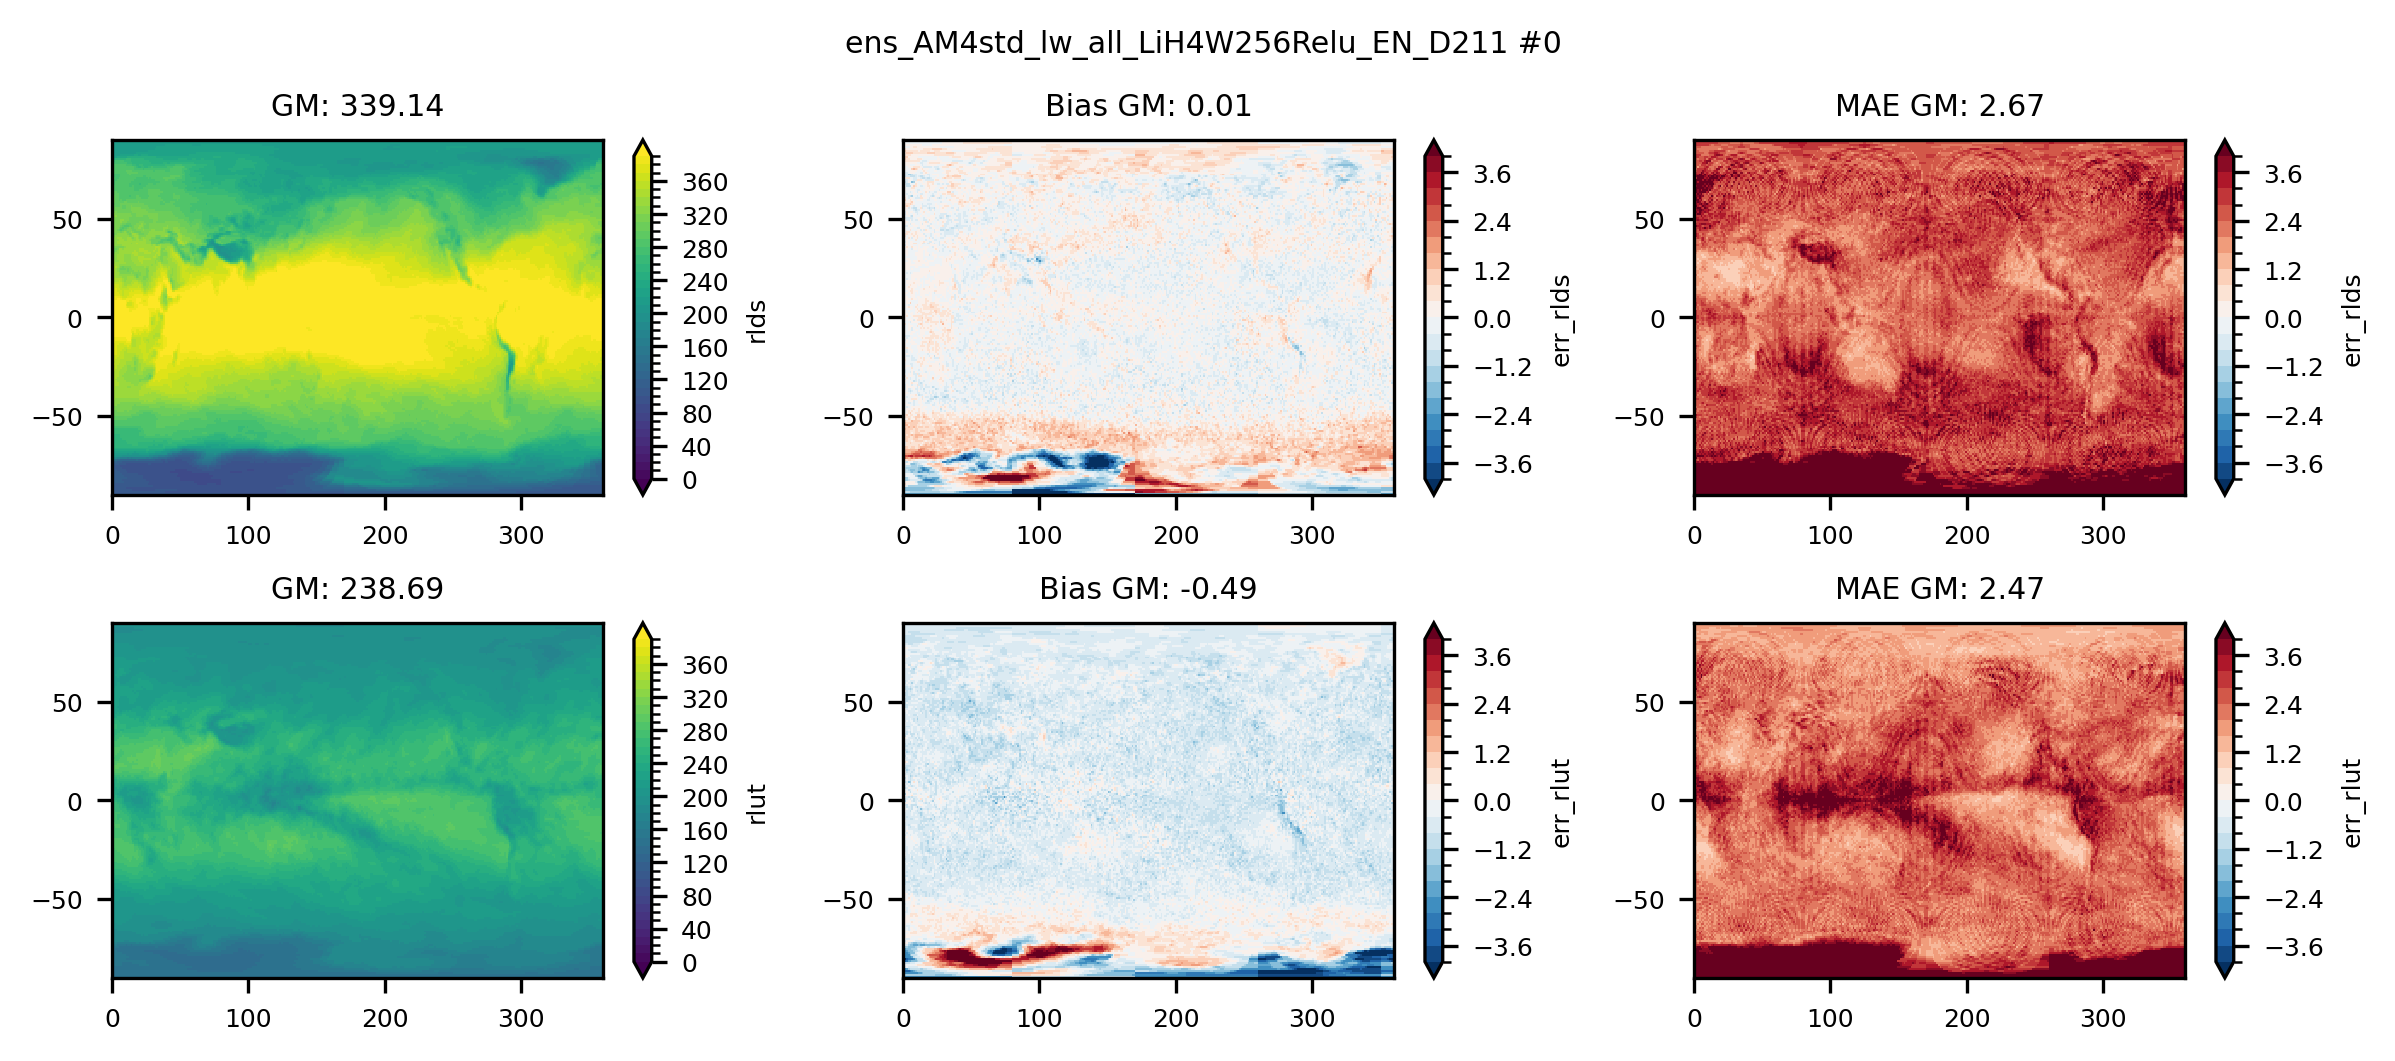

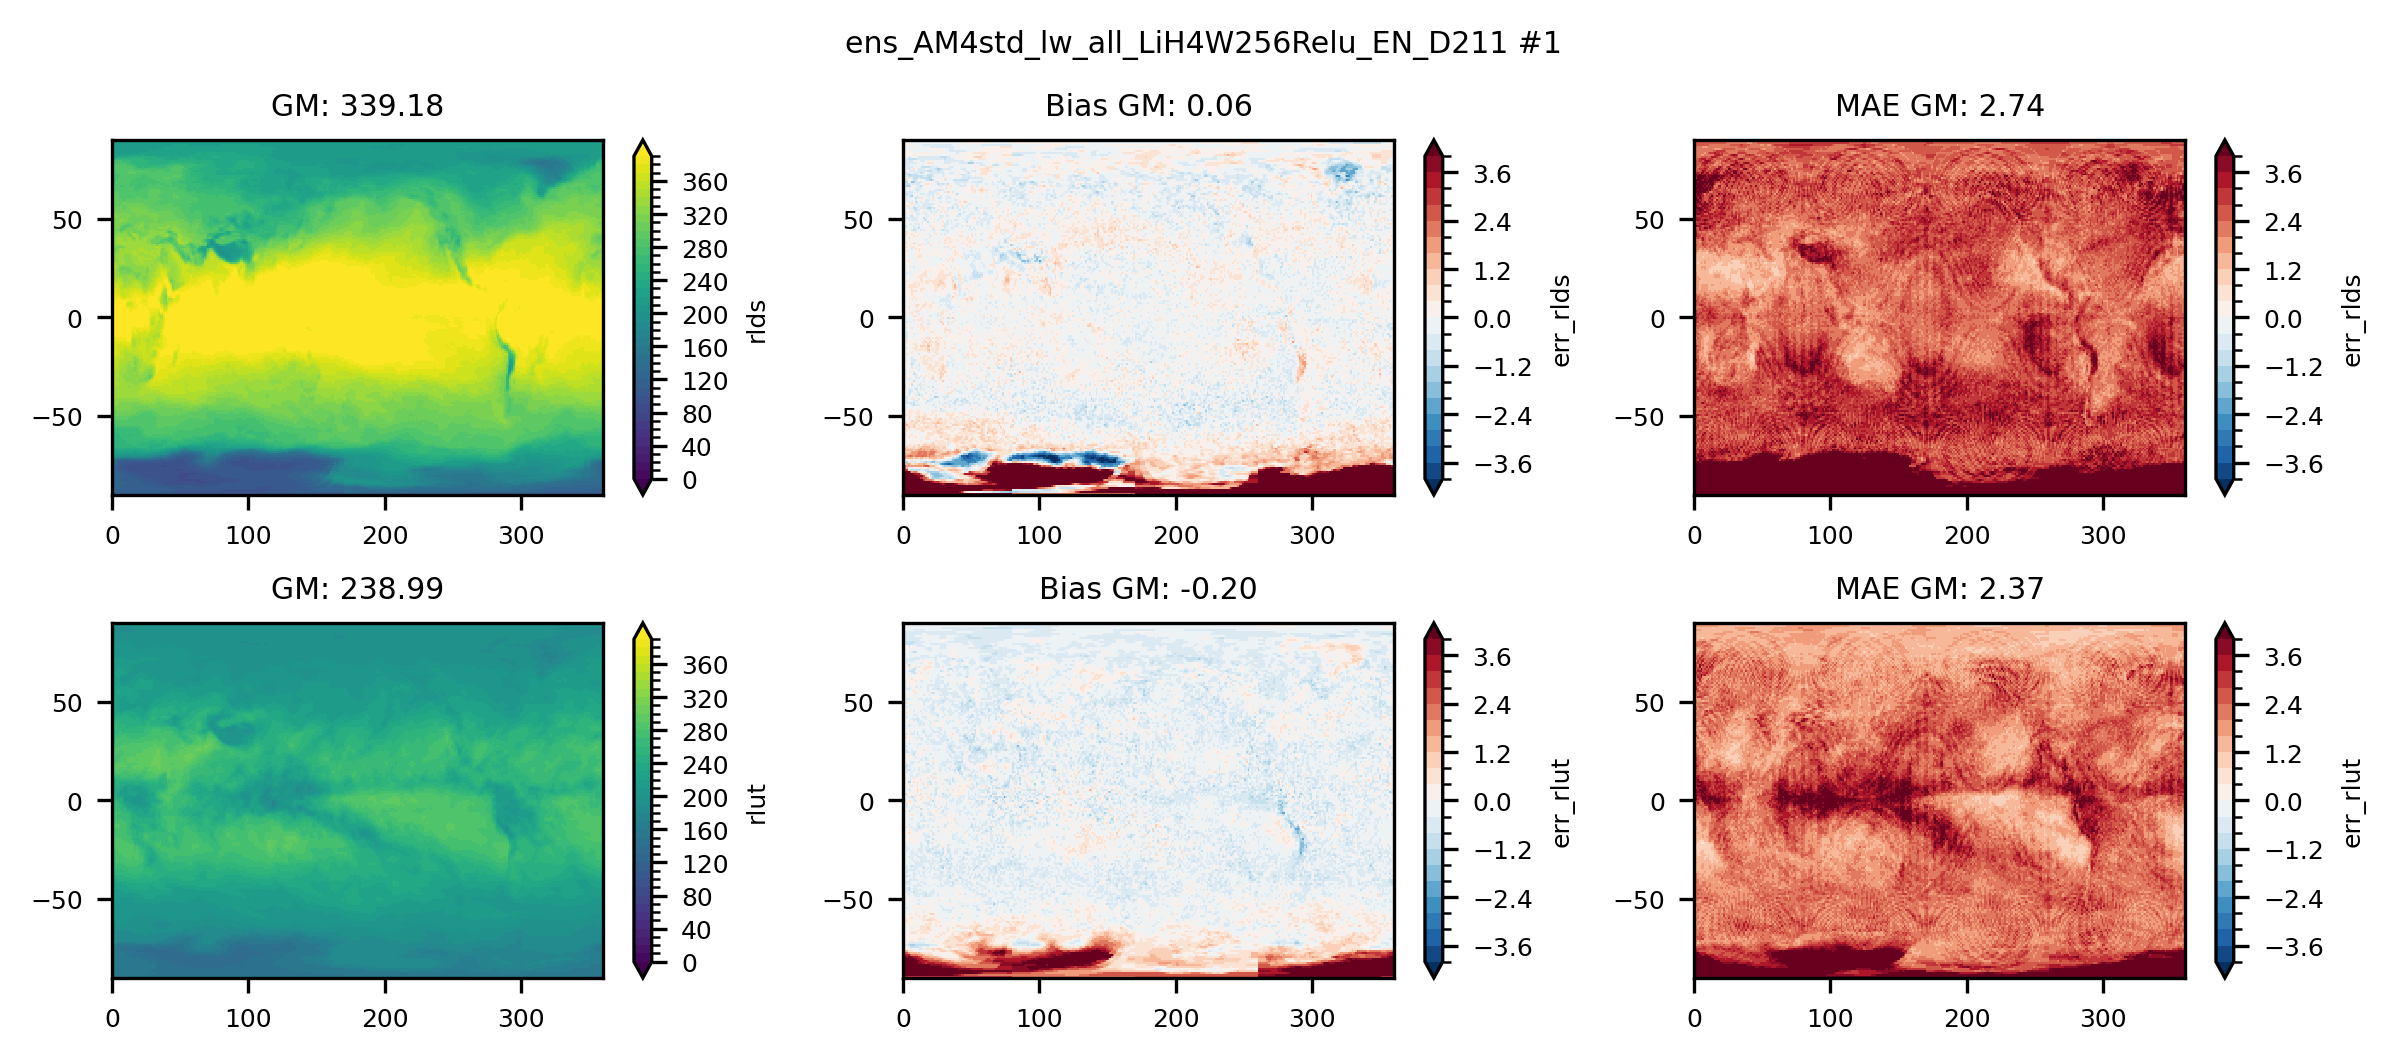

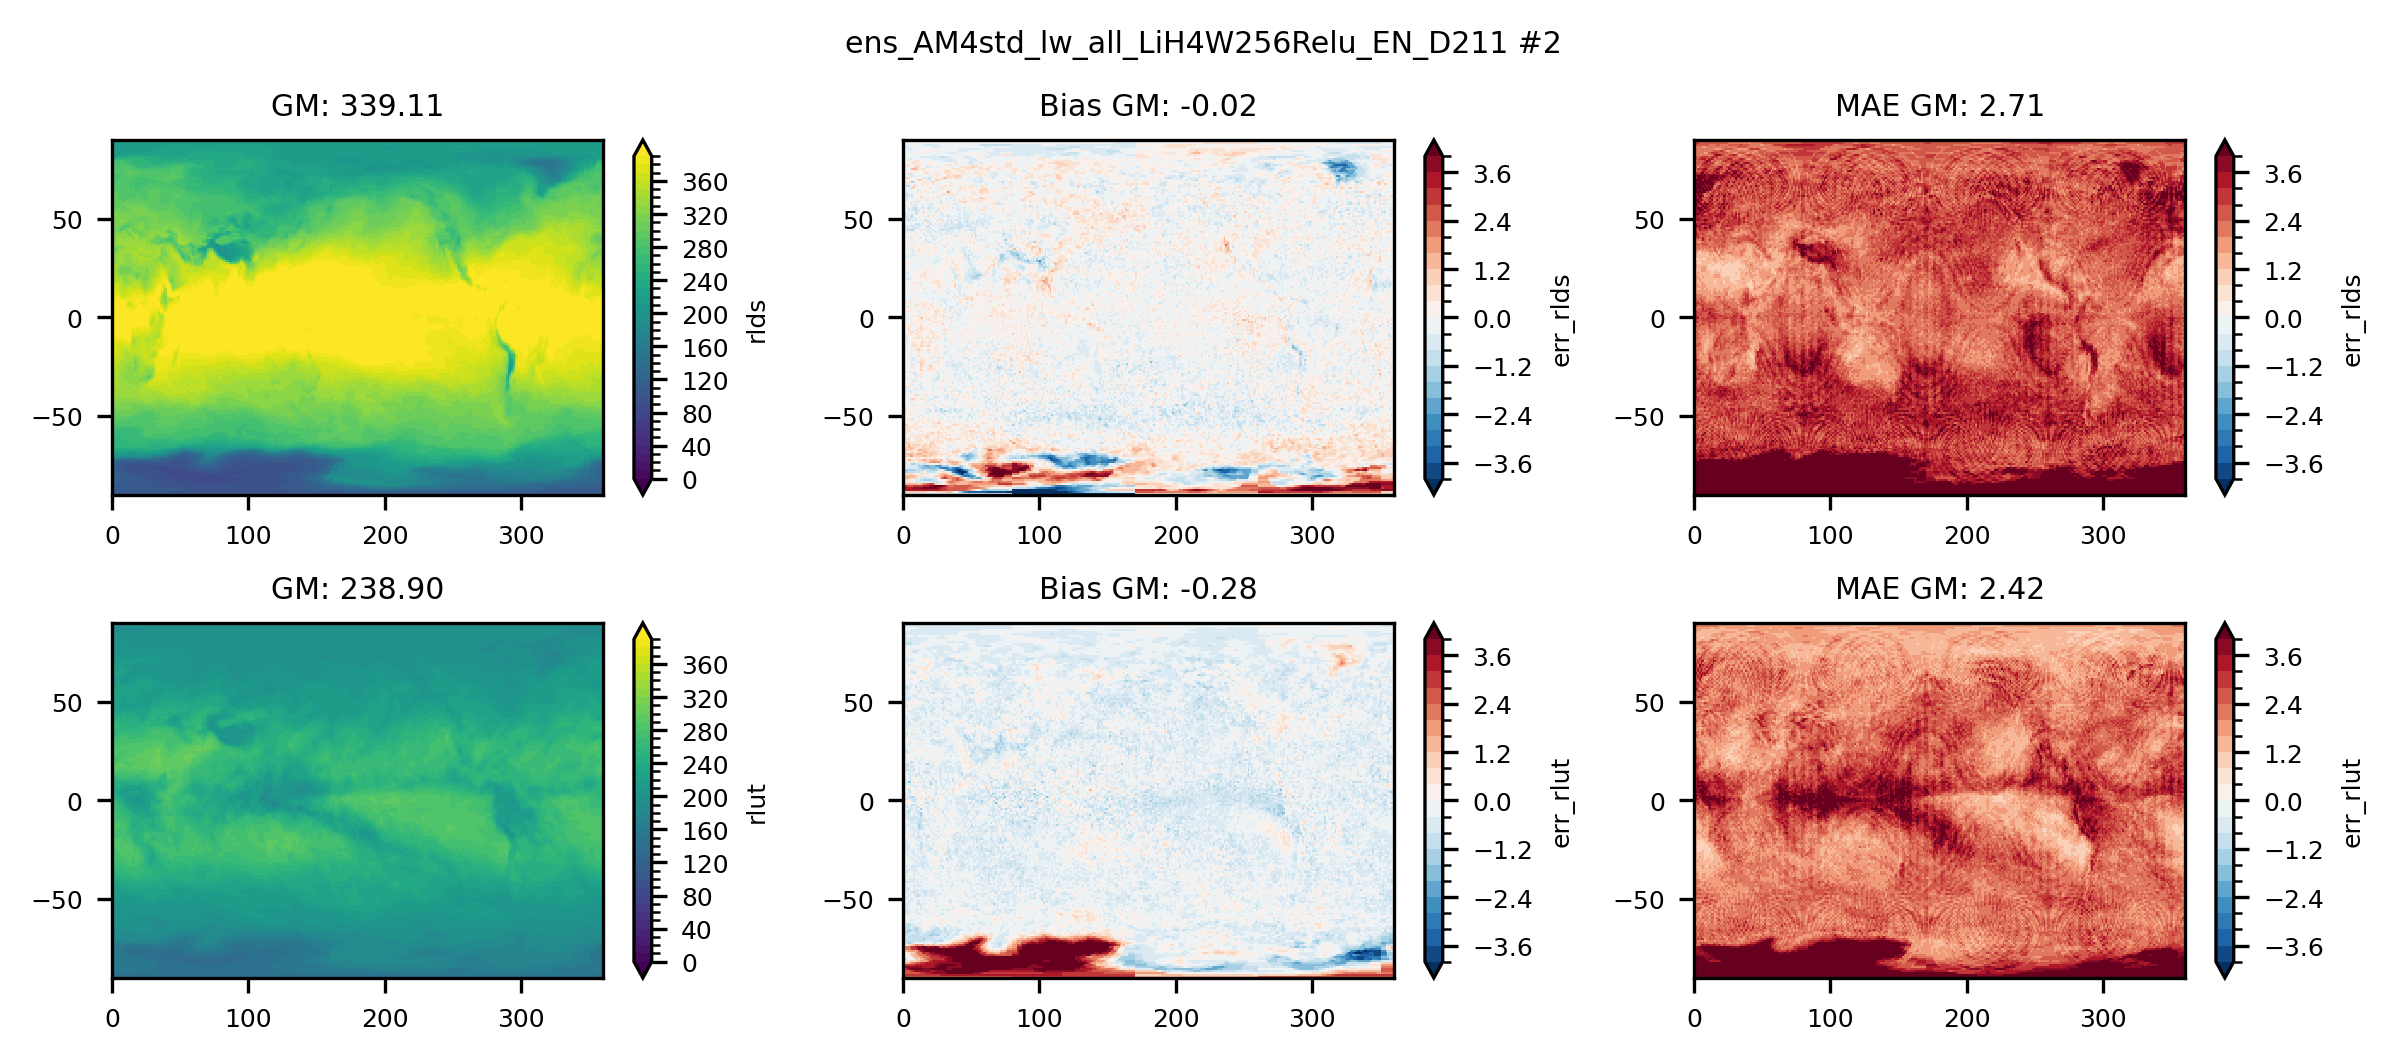

In [13]:
for mo in Exp_name:
    for ei in range(ensemble_size): 
        # time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
        # ds_plot = ds_regrid[mo][ei].isel(time=time_sel)
        ds_plot = ds_regrid[mo][ei]
        fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(8,3.5),dpi=300)
        axs = axs.flatten()
        var1 = ['rlds','rlut']
        level = np.arange(0,400,10)
        for i in range(len(var1)):
            ax=axs[3*i]
            da = ds_plot[var1[i]].mean('time')
            da.plot(ax=ax, levels=level, extend='both') 
            ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}') 
        level = np.array([-16, -8, -4,-2,-1,-0.5,-0.2,0,0.2,0.5,1,2,4,8,16]) 
        level = np.arange(-5,5.1,0.5)/5
        if sky_cond[mo] == 'all':  level = level*4
        for i in range(len(var1)):
            ax=axs[3*i+1]
            da = ds_plot['err_'+var1[i]].mean('time')
            da.plot(ax=ax, levels=level, extend='both', )   
            ax.set_title(f'Bias GM: {global_mean_xarray(da).values:4.2f}')
                         # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}')
        for i in range(len(var1)):
            ax=axs[3*i+2]
            da = abs(ds_plot['err_'+var1[i]]).mean('time') 
            da.plot(ax=ax, levels=level, extend='both', )    
            ax.set_title(f'MAE GM: {global_mean_xarray(da).values:4.2f}')
                         # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}') 
        for ax in axs:
            ax.set(xlabel=None,ylabel=None)
        plt.suptitle(f'{mo} #{ei}')
        fig.tight_layout() 

In [14]:
print('GM: Bias, MAE, RMSE')
for mo in Exp_name:
    for ei in range(ensemble_size): 
        print(f'{mo} #{ei}')
        ds_plot = ds_regrid[mo][ei]
        for i in range(len(var1)): 
            da = global_mean_xarray(ds_plot['err_'+var1[i]])
            Bias = da.mean()
            MAE  = abs(da).mean()
            RMSE = ((da**2).mean())**0.5
            print(f'err_{var1[i]}: {Bias.values:4.2f}, {MAE.values:4.2f}, {RMSE.values:4.2f},') 

GM: Bias, MAE, RMSE
ens_AM4std_lw_cs_LiH4W256Relu_EY_D211 #0
err_rlds: -0.03, 0.04, 0.05,
err_rlut: 0.04, 0.04, 0.05,
ens_AM4std_lw_cs_LiH4W256Relu_EY_D211 #1
err_rlds: -0.03, 0.06, 0.07,
err_rlut: 0.04, 0.05, 0.05,
ens_AM4std_lw_cs_LiH4W256Relu_EY_D211 #2
err_rlds: -0.01, 0.02, 0.03,
err_rlut: 0.03, 0.03, 0.04,
ens_AM4std_lw_all_LiH4W256Relu_EY_D211 #0
err_rlds: -0.02, 0.13, 0.15,
err_rlut: -0.24, 0.24, 0.26,
ens_AM4std_lw_all_LiH4W256Relu_EY_D211 #1
err_rlds: -0.01, 0.07, 0.08,
err_rlut: -0.33, 0.33, 0.34,
ens_AM4std_lw_all_LiH4W256Relu_EY_D211 #2
err_rlds: 0.09, 0.10, 0.12,
err_rlut: -0.21, 0.21, 0.23,
ens_AM4std_lw_cs_LiH4W256Relu_EN_D211 #0
err_rlds: 0.04, 0.08, 0.09,
err_rlut: -0.03, 0.05, 0.08,
ens_AM4std_lw_cs_LiH4W256Relu_EN_D211 #1
err_rlds: 0.09, 0.20, 0.26,
err_rlut: 0.18, 0.18, 0.26,
ens_AM4std_lw_cs_LiH4W256Relu_EN_D211 #2
err_rlds: 0.09, 0.09, 0.12,
err_rlut: 0.07, 0.08, 0.09,
ens_AM4std_lw_all_LiH4W256Relu_EN_D211 #0
err_rlds: 0.01, 0.07, 0.09,
err_rlut: -0.49, 0.49, 0.

In [15]:
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

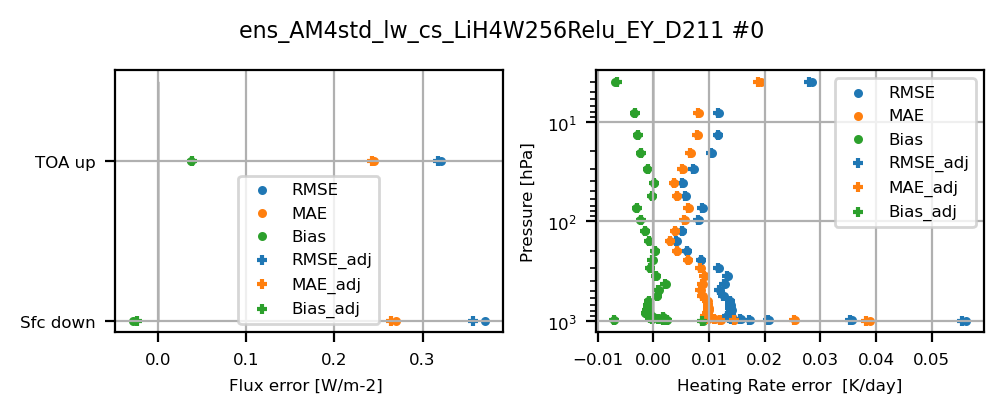

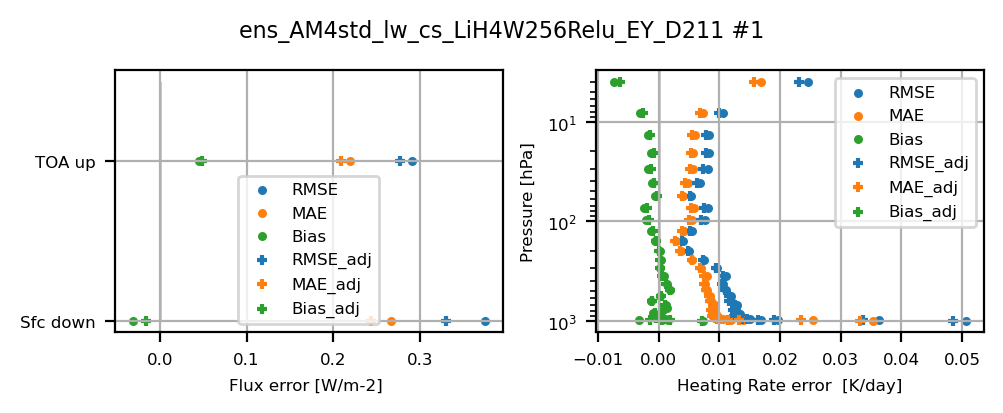

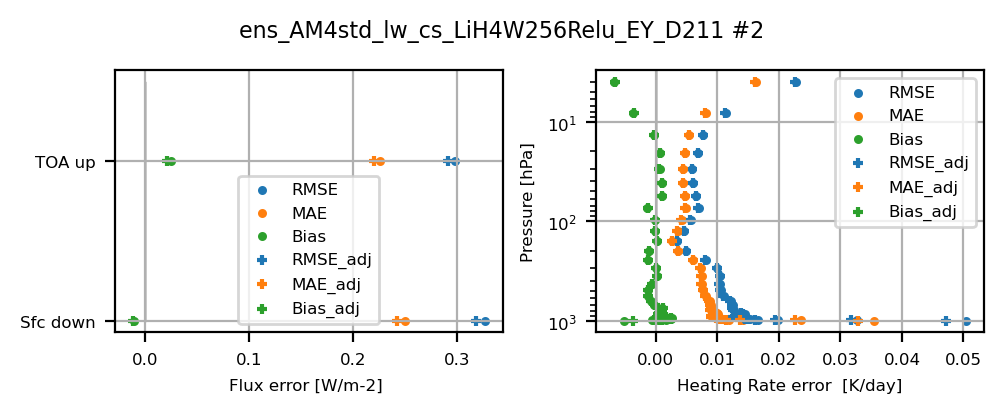

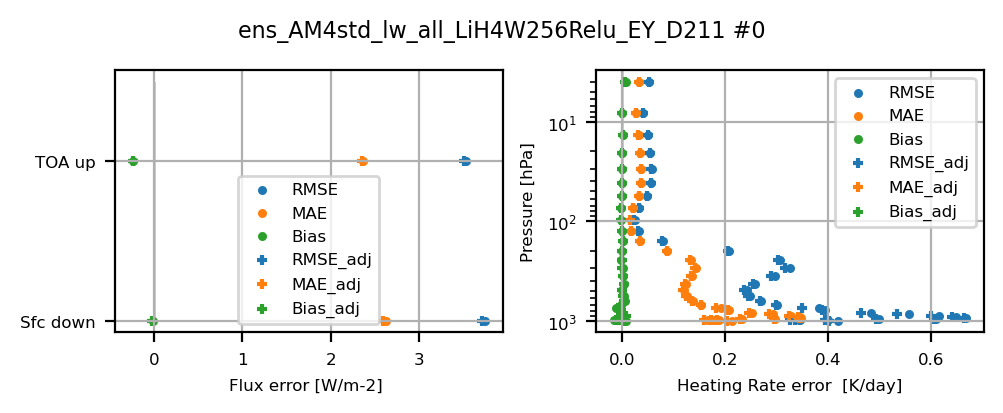

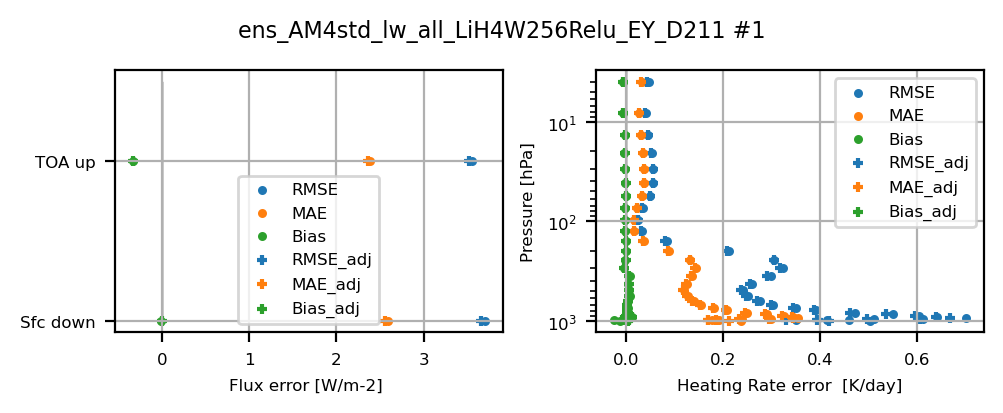

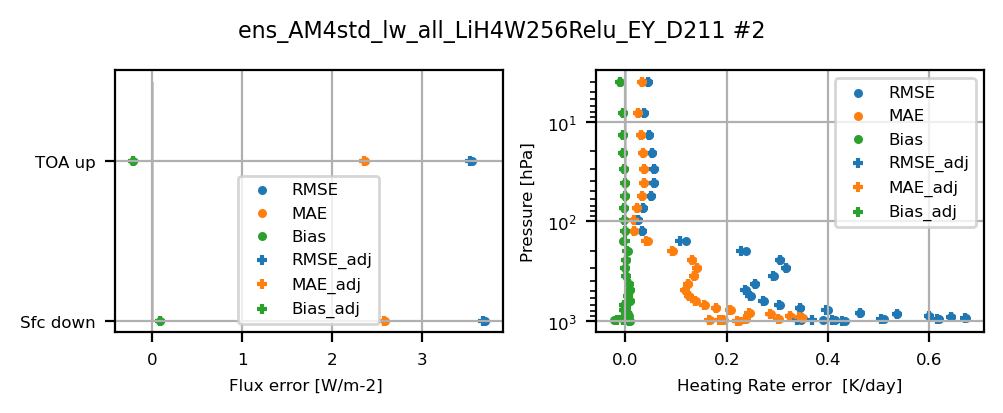

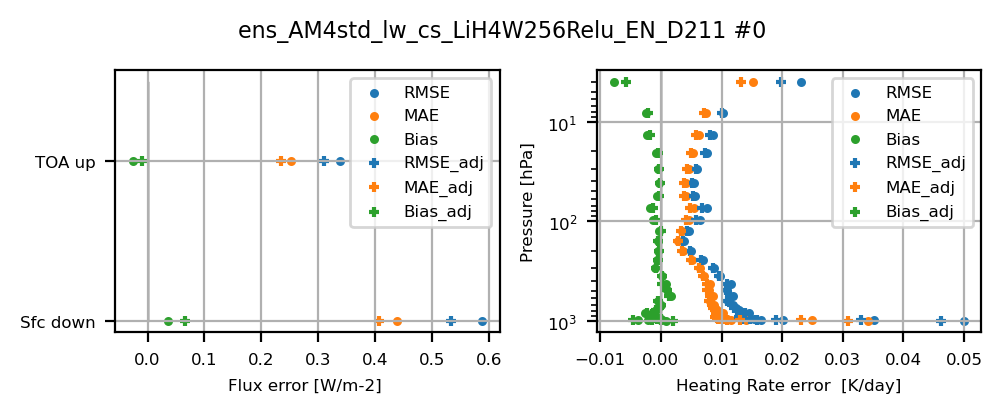

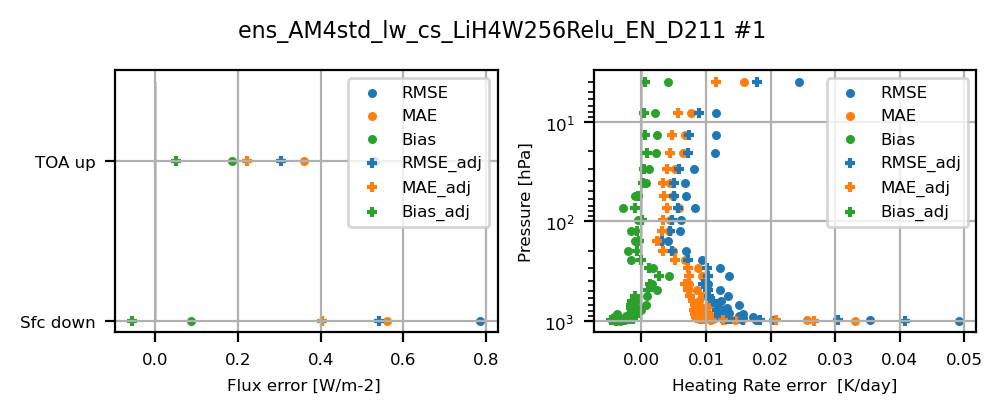

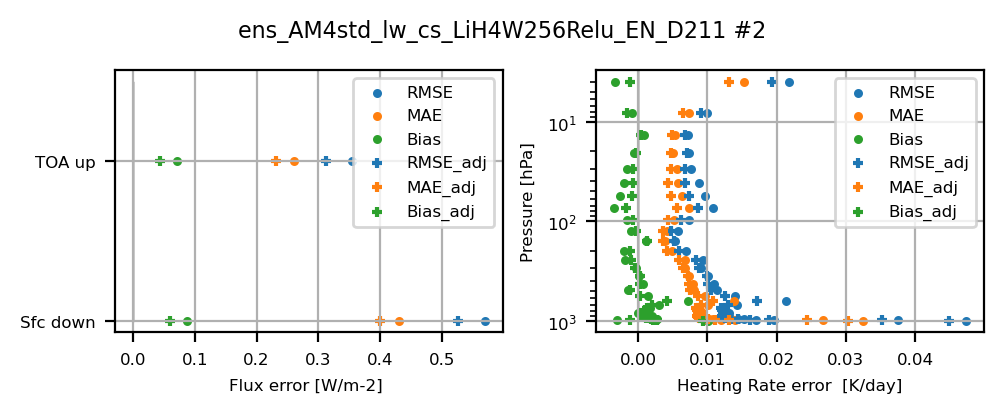

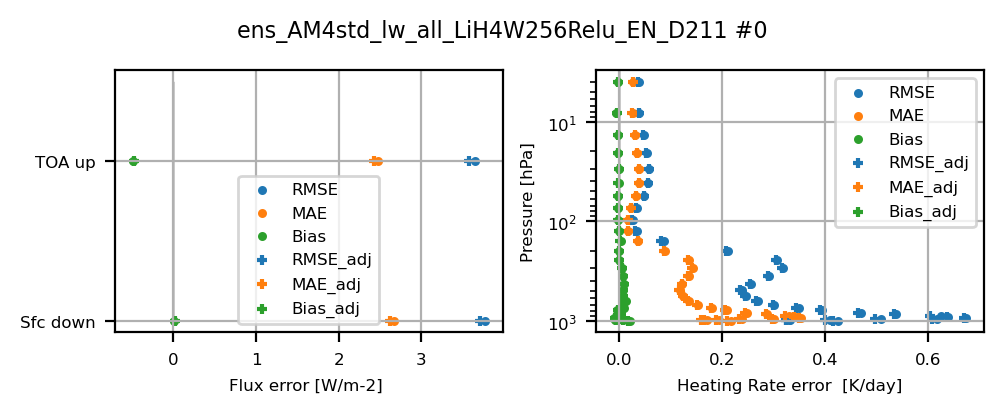

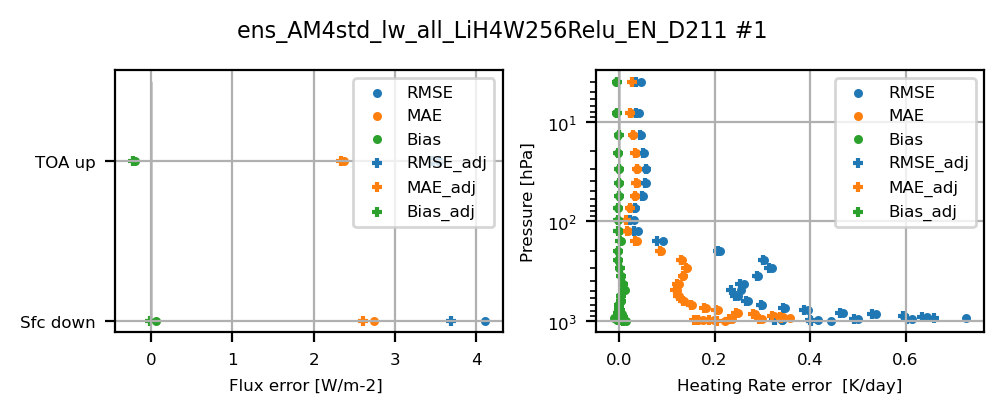

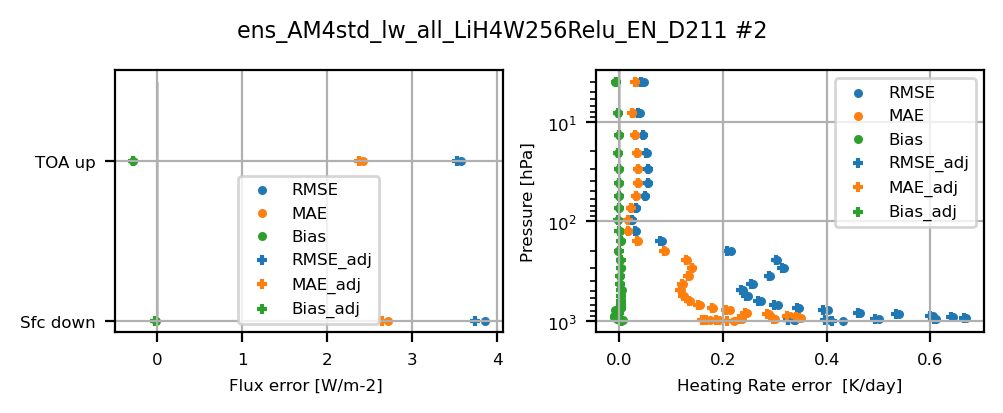

In [16]:
for i, mo in enumerate(Exp_name):
    for ei in range(ensemble_size): 
        RMSE = []
        MAE  = []
        Bias = []
        RMSE_adj = []
        MAE_adj  = []
        Bias_adj = []
        ds = ds_regrid[mo][ei]
        err_var = [ 'err_rlds','err_rlut','err_tntrl' ]  
        for i in range(len(err_var)): 
            da = ds[err_var[i]].mean('time')
            Bias.append(global_mean_xarray(da).values) 
            da = abs(ds[err_var[i]]).mean('time')
            MAE .append(global_mean_xarray(da).values) 
            da = ((ds[err_var[i]]**2).mean('time'))**0.5
            RMSE.append(global_mean_xarray(da).values) 
            da_adj = xr.where(abs(ds['err_eng'])<10, ds[err_var[i]], 0)
            da = da_adj.mean('time') 
            Bias_adj.append(global_mean_xarray(da).values) 
            da = abs(da_adj).mean('time')
            MAE_adj .append(global_mean_xarray(da).values) 
            da = ((da_adj**2).mean('time'))**0.5
            RMSE_adj.append(global_mean_xarray(da).values) 
        # plt.style.use('default')
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5,2),dpi=200) 
        axs=axs.flatten() 
        ax3=axs[0] # error
        ax4=axs[1] # error 
        
        ax3.set_prop_cycle(None)
        ax3.scatter(RMSE[:2], np.arange(2),  s=5, label='RMSE')
        ax3.scatter(MAE [:2], np.arange(2),  s=5, label='MAE')
        ax3.scatter(Bias[:2], np.arange(2),  s=5, label='Bias')
        ax3.set_prop_cycle(None)
        ax3.scatter(RMSE_adj[:2], np.arange(2),  s=15, marker='+', label='RMSE_adj')
        ax3.scatter(MAE_adj [:2], np.arange(2),  s=15, marker='+', label='MAE_adj')
        ax3.scatter(Bias_adj[:2], np.arange(2),  s=15, marker='+', label='Bias_adj')
        ax3.plot([0,0],[0,1.5],c='k',linewidth = 0.5, zorder=0)
        ax3.set_yticks([0,1], labels=[ 'Sfc down','TOA up',])
        ax3.legend(fontsize=6)
        ax3.set_xlabel('Flux error [W/m-2] ')
        ax3.grid(True)
    #     ax3.set_xlim([-0.1,1.2])

        ax4.set_prop_cycle(None)
        ax4.scatter(RMSE[2], z_lev[1:],  s=5, label='RMSE')
        ax4.scatter(MAE [2], z_lev[1:],  s=5, label='MAE') 
        ax4.scatter(Bias[2], z_lev[1:],  s=5, label='Bias')
        ax4.set_prop_cycle(None)
        ax4.scatter(RMSE_adj[2], z_lev[1:],  s=15, marker='+', label='RMSE_adj')
        ax4.scatter(MAE_adj [2], z_lev[1:],  s=15, marker='+', label='MAE_adj') 
        ax4.scatter(Bias_adj[2], z_lev[1:],  s=15, marker='+', label='Bias_adj')
        ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
        ax4.legend(fontsize=6)
        ax4.invert_yaxis()
        ax4.set_yscale('log') 
        ax4.grid(True)
    #     ax4.set_xlim([-0.04,0.4])
        ax4.set_xlabel('Heating Rate error  [K/day]')
        ax4.set_ylabel('Pressure [hPa]') 
        plt.suptitle(f'{mo} #{ei}',fontsize=8)
        fig.tight_layout()
        fig.show() 

# energy check

In [17]:
std_nor_vars_name  = [ 'rlds','rlut','tntrl' ] 
std_nor_vars_gn = {}
err_vars_name = ['err_eng','err_rlds','err_rlut','err_tntrl' ] 
err_vars_gn = {}  
for mo in Exp_name: 
    err_vars_gn[mo] = []
    std_nor_vars_gn[mo] = []
    for ei in range(ensemble_size):
        err_ei_dict = {}
        var_ei_dict = {}
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        NN_output_name = f'NN_{ei}_20000101.fluxes' 
        for var in err_vars_name:
            err_ei_dict[var] = []
        for var in std_nor_vars_name:
            var_ei_dict[var] = []
        for ti in range(1,7):
            tile_file_path = exp_dir+f'/NN_pred/{NN_output_name}.tile{ti}.nc'
            print(tile_file_path)
            # open regridded file
            with  xr.open_dataset(tile_file_path) as ds:
                for var in err_vars_name: 
                    err_ei_dict[var].append(ds[var].stack(txy=("time","grid_yt", "grid_xt")).values.T) 
                for var in std_nor_vars_name:
                    var_ei_dict[var].append(ds[var].stack(txy=("time","grid_yt", "grid_xt")).values.T) 
        for var in err_vars_name:
            err_ei_dict[var] = np.concatenate(err_ei_dict[var]) 
        for var in std_nor_vars_name:
            var_ei_dict[var] = np.concatenate(var_ei_dict[var])
        err_vars_gn[mo].append(err_ei_dict)
        std = np.concatenate([np.atleast_1d(var_ei_dict[var].std(axis=0))  for var in std_nor_vars_name])
        std_nor_vars_gn[mo].append(std) 

/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.tile1.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.tile2.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.tile3.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.tile4.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.tile5.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_0_20000101.fluxes.tile6.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_1_20000101.fluxes.tile1.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_1_20000101.fluxes.tile2.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_lw_cs_LiH4W256Relu_EY_D211/NN_pred/NN_1_20000101

## exclude large energe error columns

In [18]:
for i, mo in enumerate(Exp_name): 
    for ei in range(ensemble_size): 
        err_eng_arr = err_vars_gn[mo][ei]['err_eng']
        ind_small_eng_err = np.argwhere(abs(err_eng_arr)<2)
        print(f"{mo} #{ei} good ratio: {ind_small_eng_err.size/err_eng_arr.size:4.2f}")
        rd_id_more = np.random.randint(0,ind_small_eng_err.shape[0],1000000) 
        ind_small_eng_err = ind_small_eng_err[rd_id_more] 
        err_var_arr = np.stack([err_vars_gn[mo][ei]['err_rlds'],
                                err_vars_gn[mo][ei]['err_rlut']])
        RMSE = ((err_var_arr[:,ind_small_eng_err]**2).mean(axis=1)).squeeze()**0.5
        MAE  = abs(err_var_arr[:,ind_small_eng_err]).mean(axis=1).squeeze()
        Bias = err_var_arr[:,ind_small_eng_err].mean(axis=1).squeeze()
        print('filtered',Bias[:2],MAE[:2],RMSE[:2])
        rd_id_more = np.random.randint(0,err_eng_arr.shape[0],1000000) 
        RMSE = ((err_var_arr[:,rd_id_more]**2).mean(axis=1))**0.5
        MAE  = abs(err_var_arr[:,rd_id_more]).mean(axis=1)
        Bias = err_var_arr[:,rd_id_more].mean(axis=1)
        print('raw     ',Bias[:2],MAE[:2],RMSE[:2])

ens_AM4std_lw_cs_LiH4W256Relu_EY_D211 #0 good ratio: 0.99
filtered [-0.03695593  0.0145871 ] [0.26288497 0.24387911] [0.39584816 0.39759067]
raw      [-0.02905236  0.02673248] [0.29210162 0.2618209 ] [0.5985149 0.5041296]
ens_AM4std_lw_cs_LiH4W256Relu_EY_D211 #1 good ratio: 0.99
filtered [-0.02983553  0.03159719] [0.24242282 0.22032699] [0.35035682 0.3194853 ]
raw      [-0.02930687  0.03936443] [0.28299016 0.23924108] [0.7628023 0.4454176]
ens_AM4std_lw_cs_LiH4W256Relu_EY_D211 #2 good ratio: 0.99
filtered [0.01185238 0.01186972] [0.2501003  0.23039119] [0.37368035 0.35196933]
raw      [-0.00299559  0.01860183] [0.27317744 0.24576728] [0.5693864  0.48263207]
ens_AM4std_lw_all_LiH4W256Relu_EY_D211 #0 good ratio: 0.98
filtered [-0.0473489  -0.21025872] [3.806658  3.5030825] [5.9848895 5.7209234]
raw      [-0.02702216 -0.2234378 ] [3.8589132 3.5278692] [6.073367  5.7488813]
ens_AM4std_lw_all_LiH4W256Relu_EY_D211 #1 good ratio: 0.98
filtered [-0.01655432 -0.32452518] [3.819633  3.5166786] [

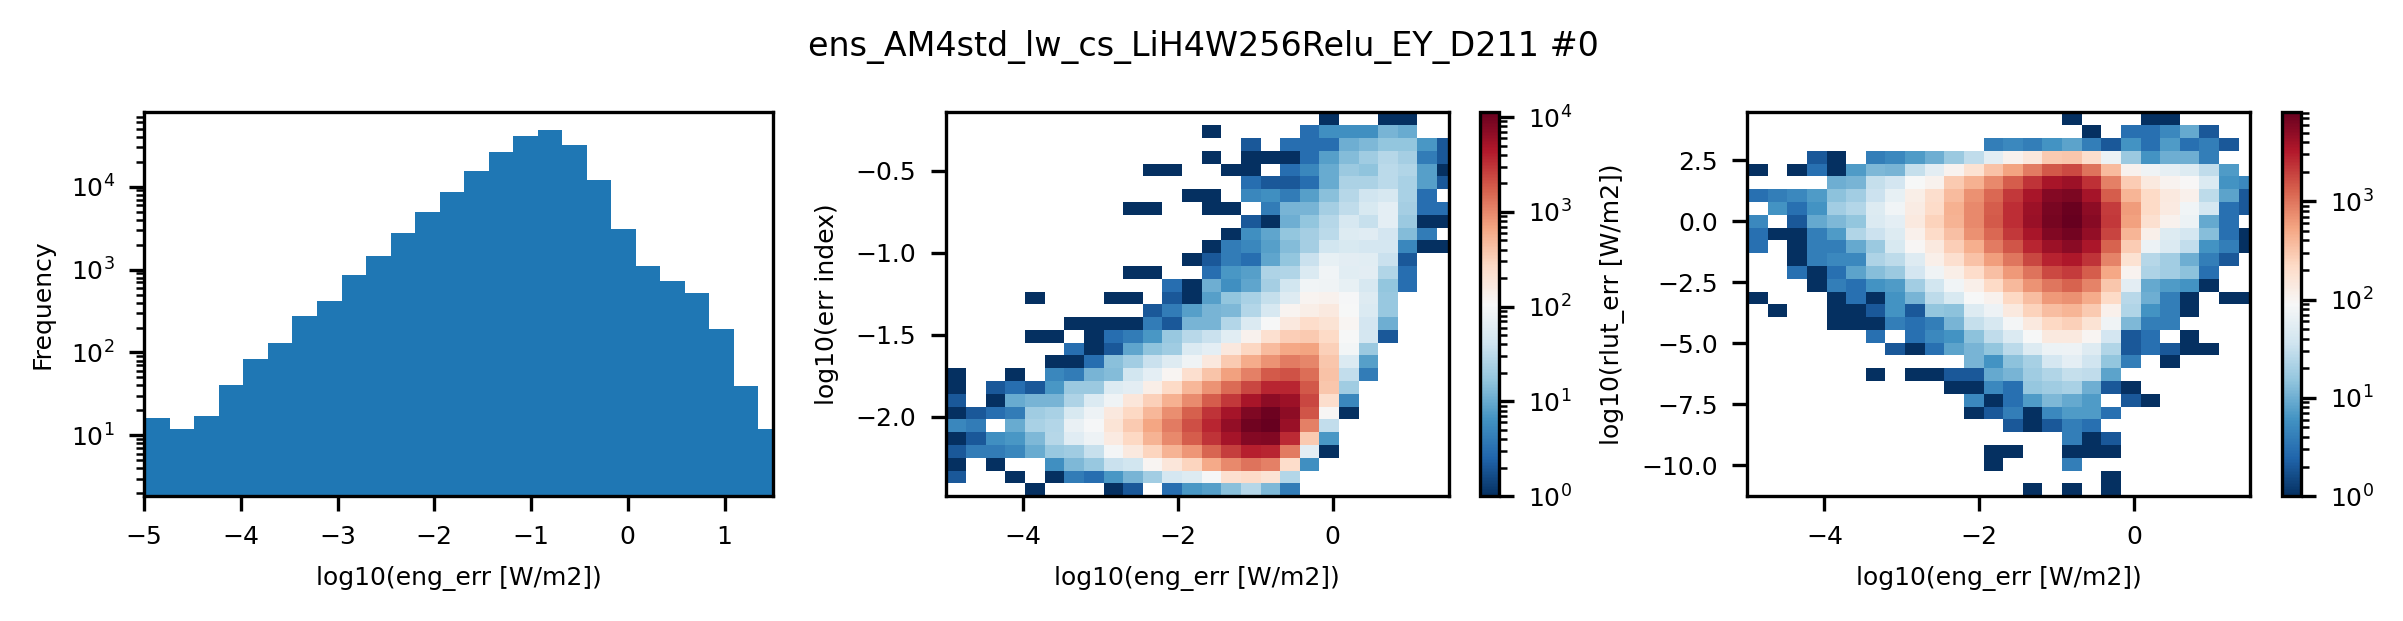

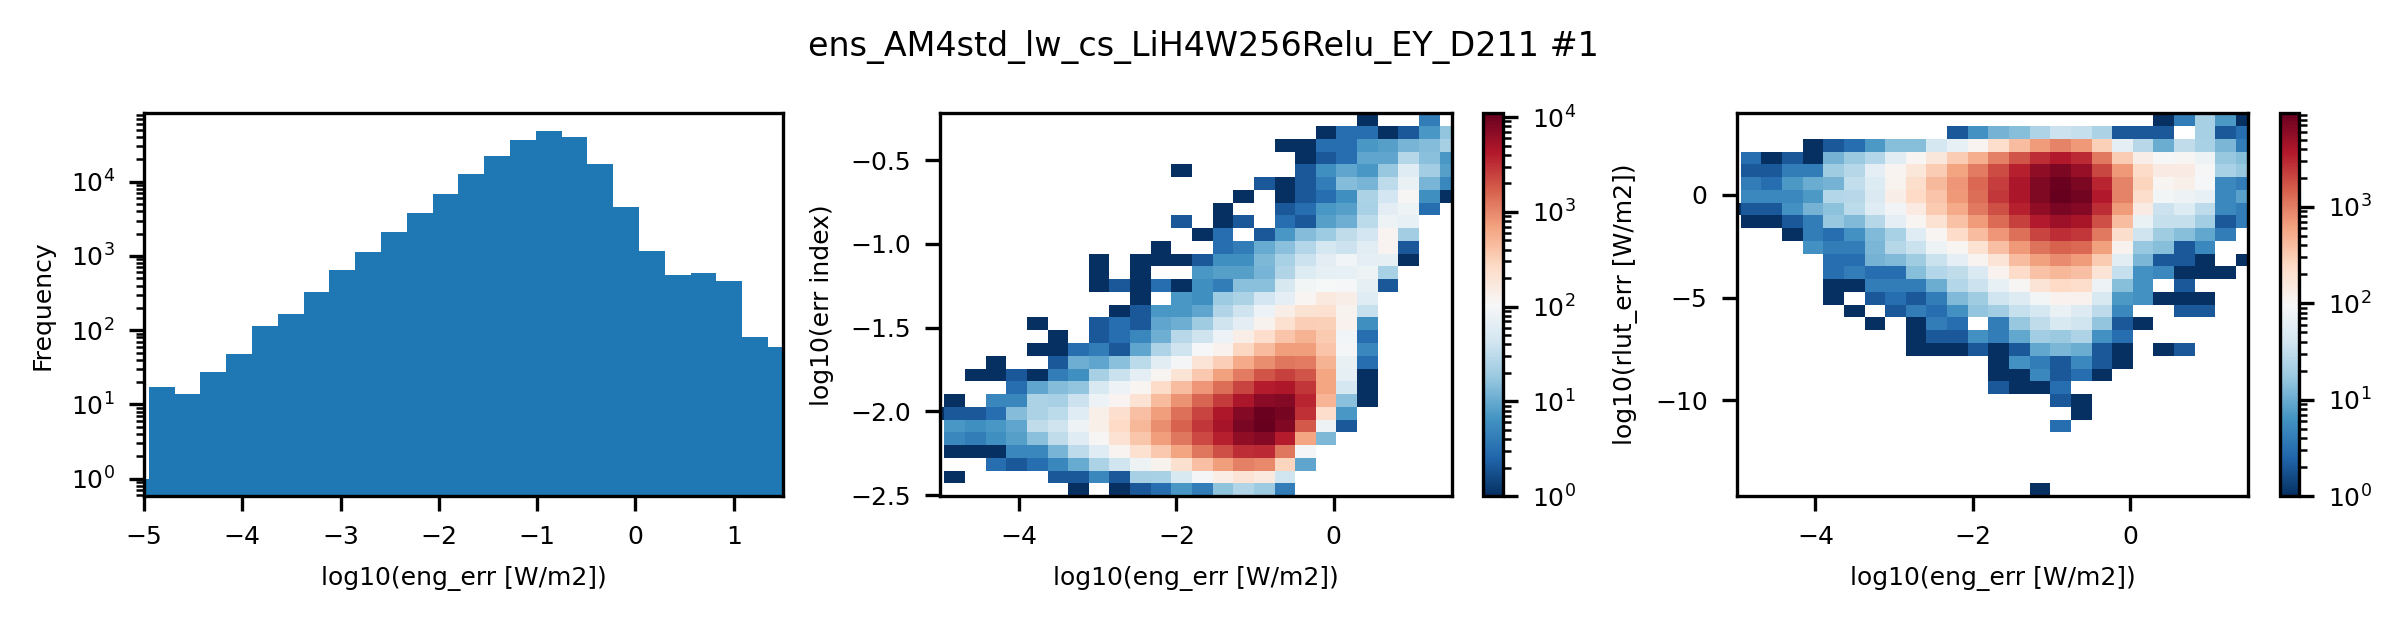

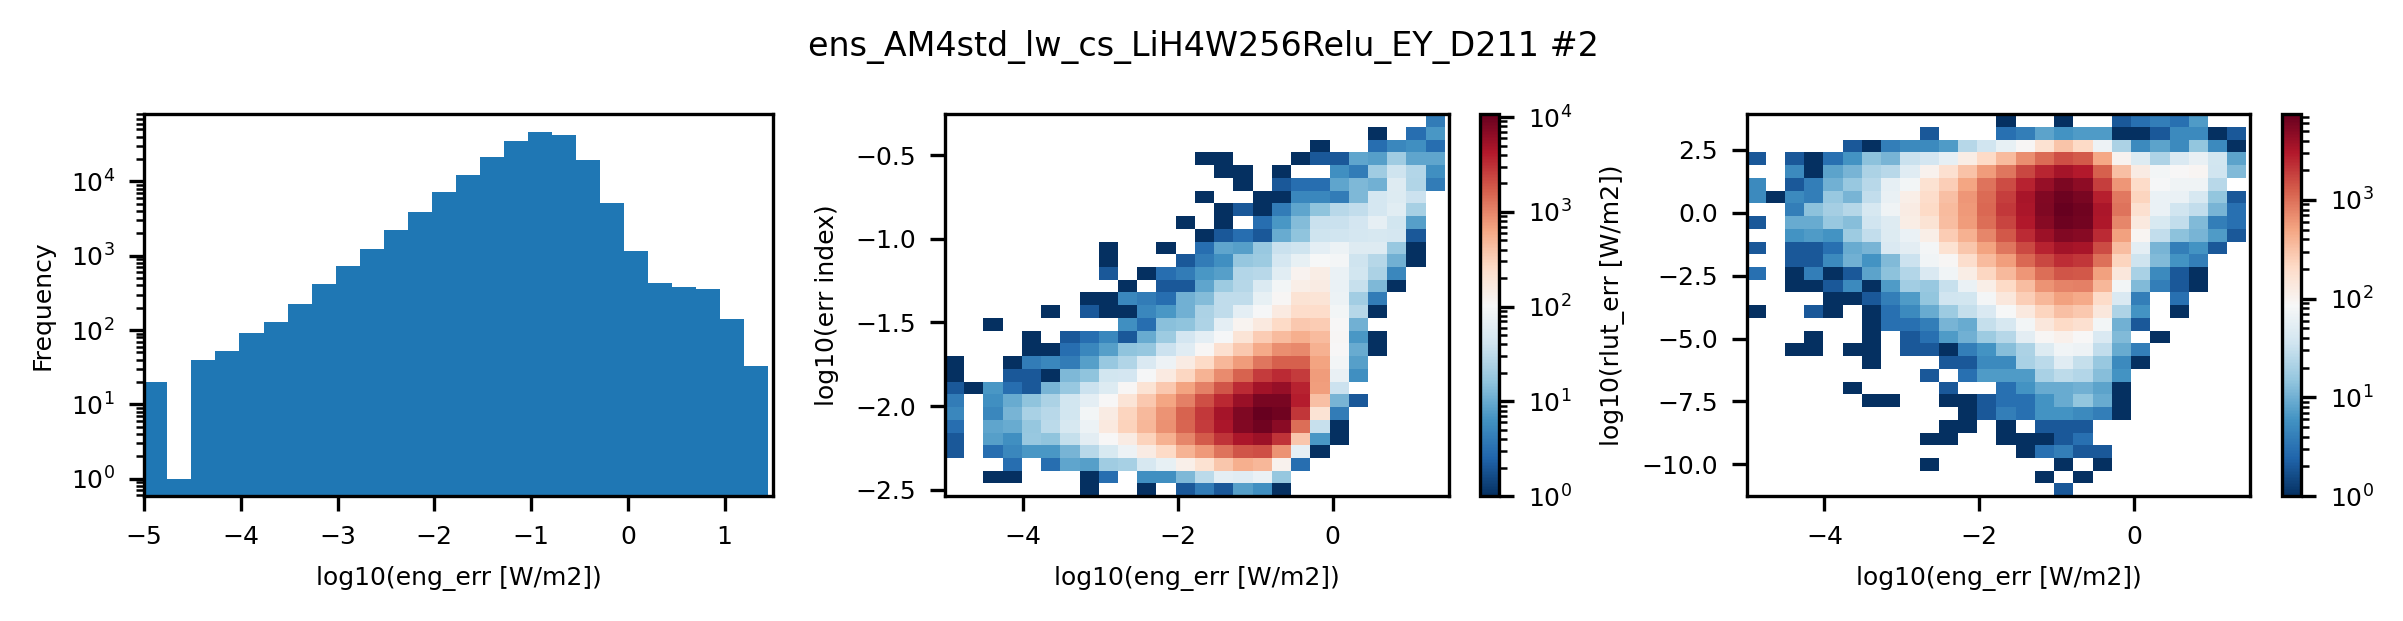

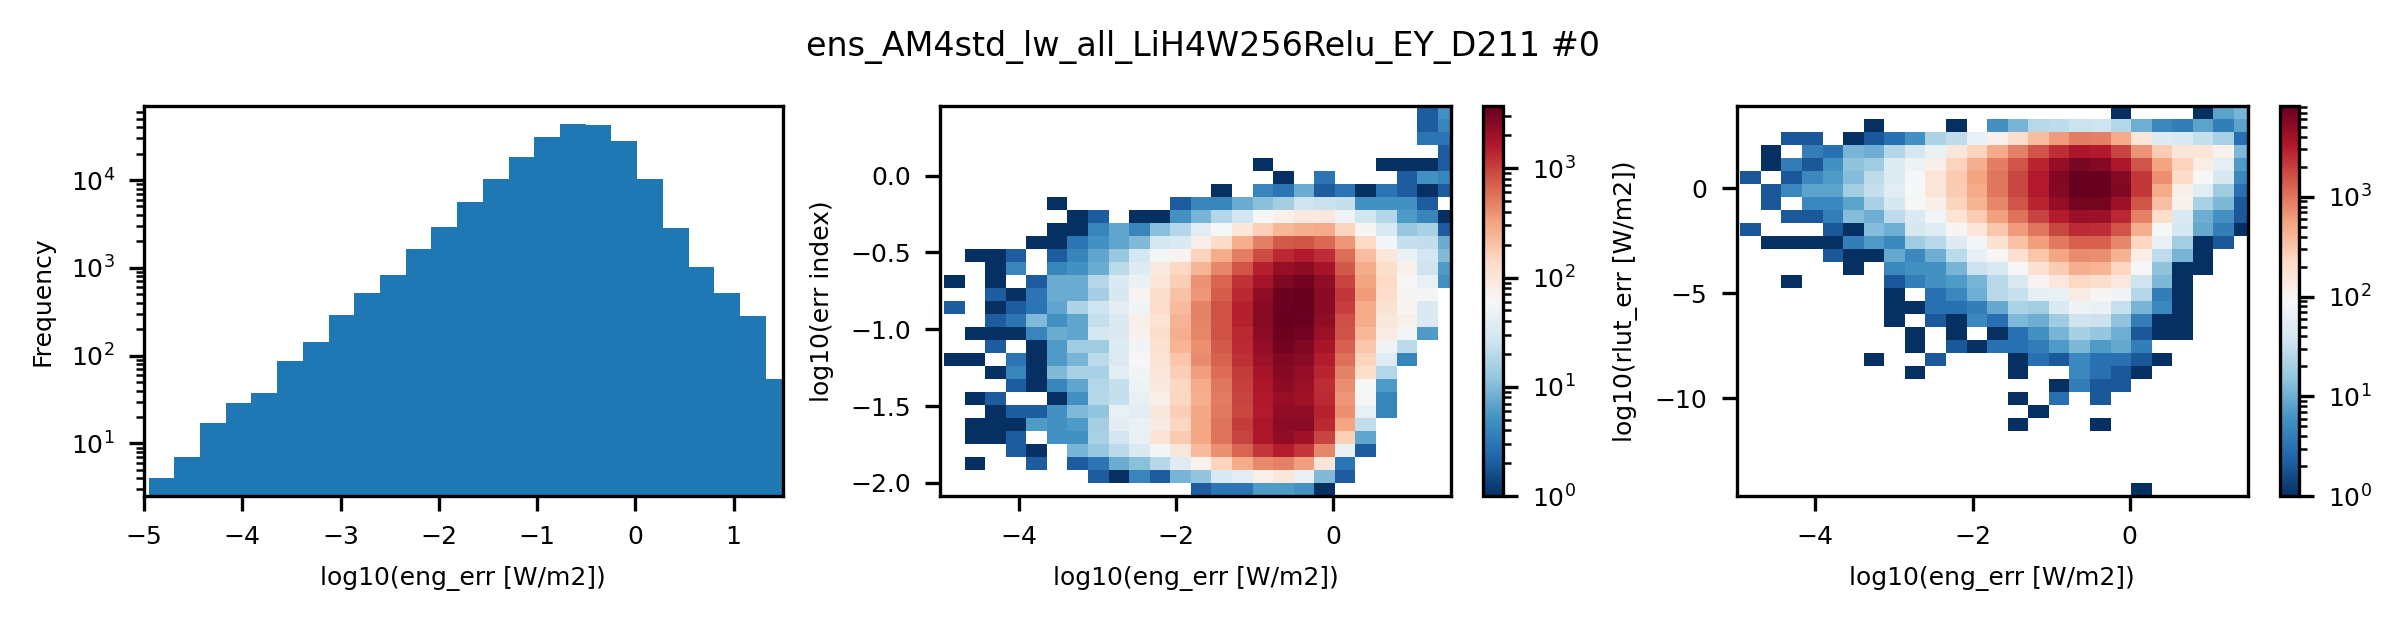

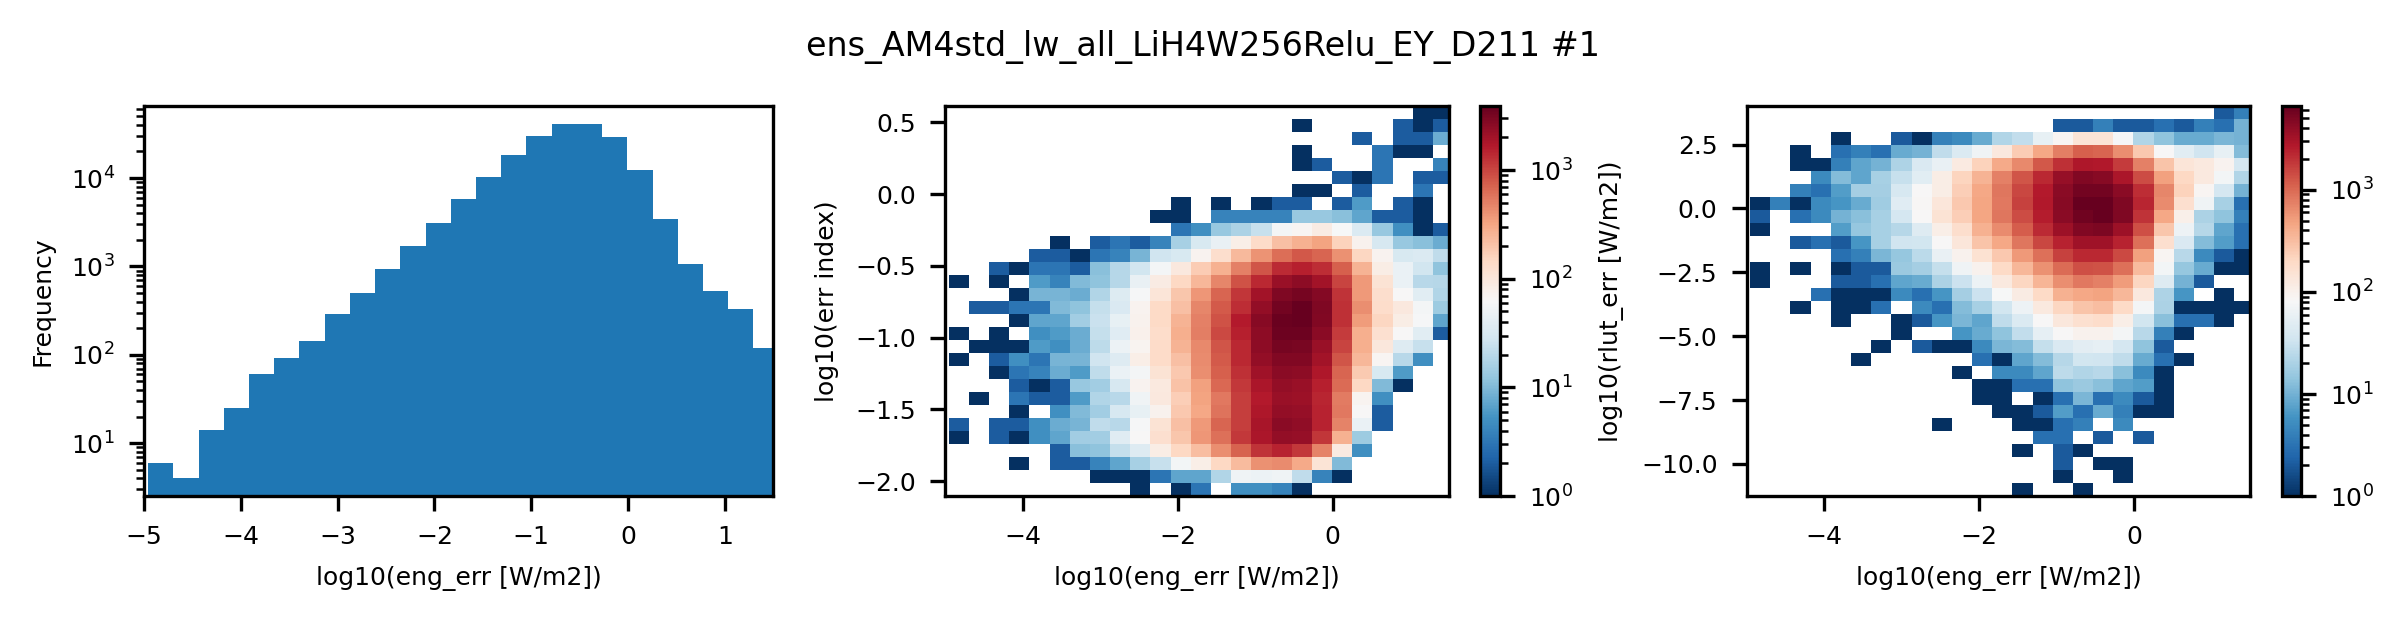

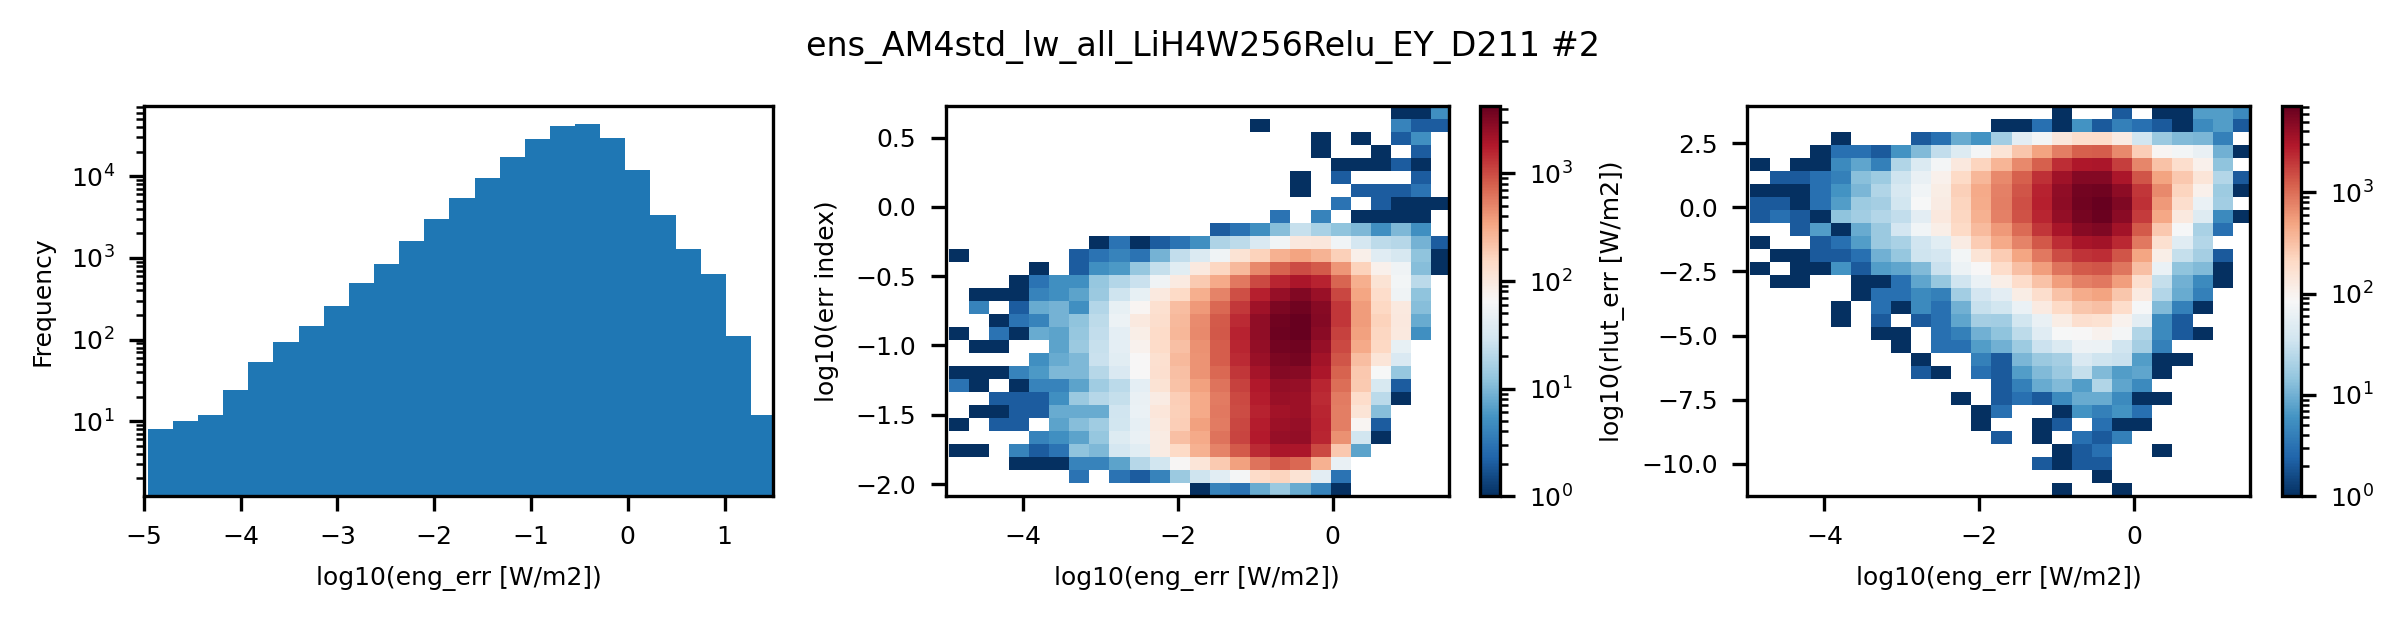

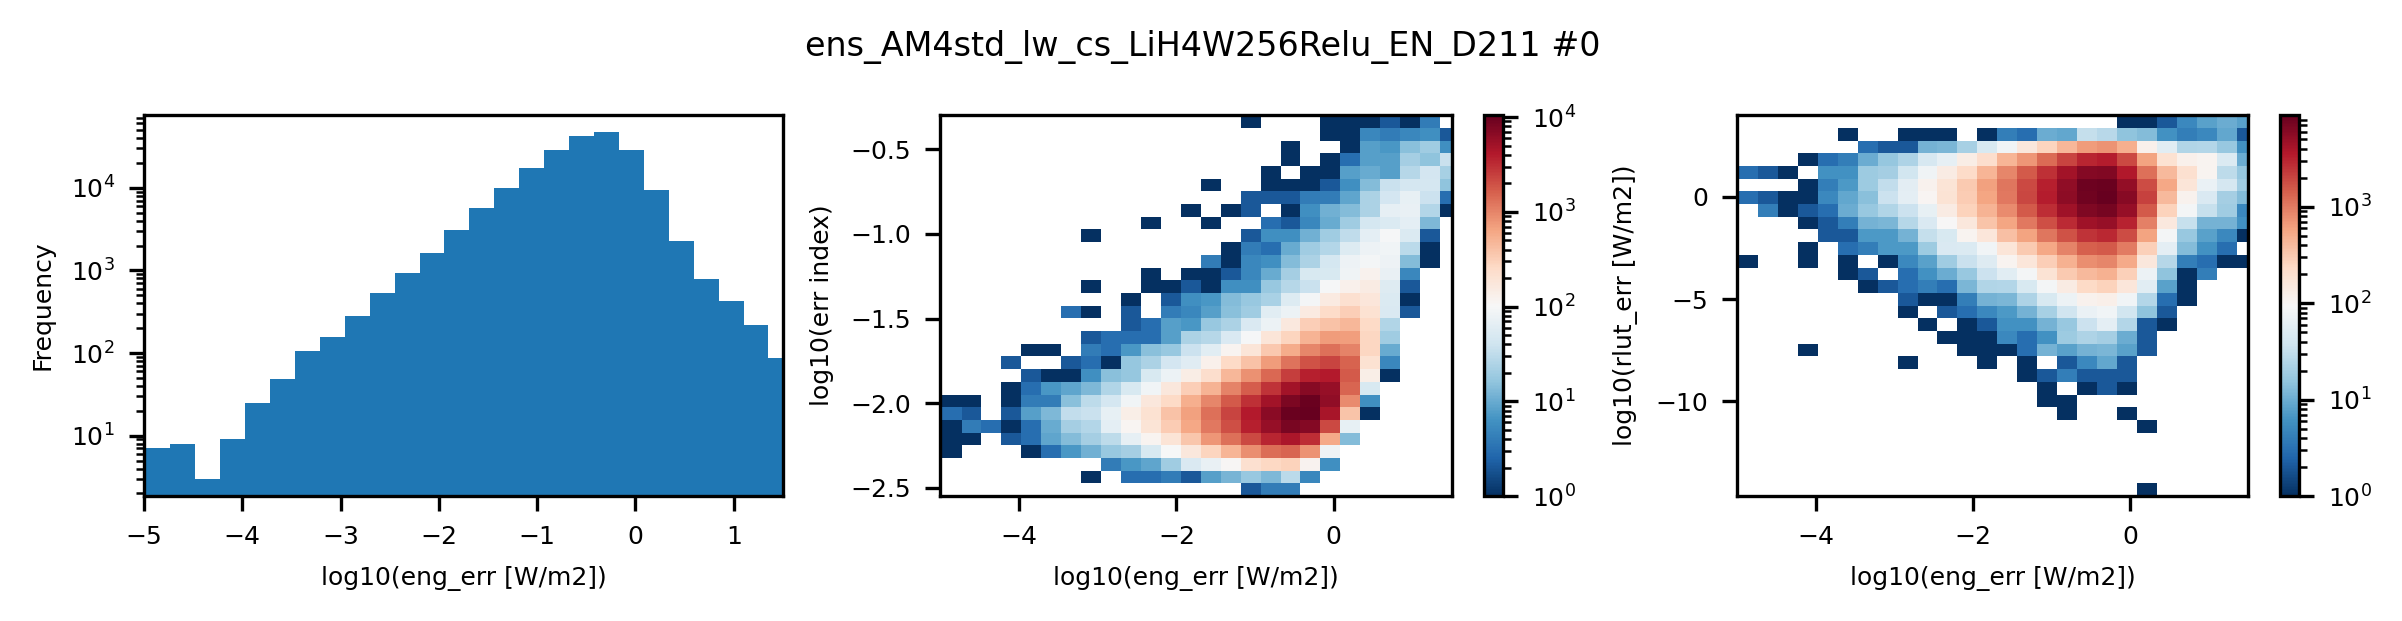

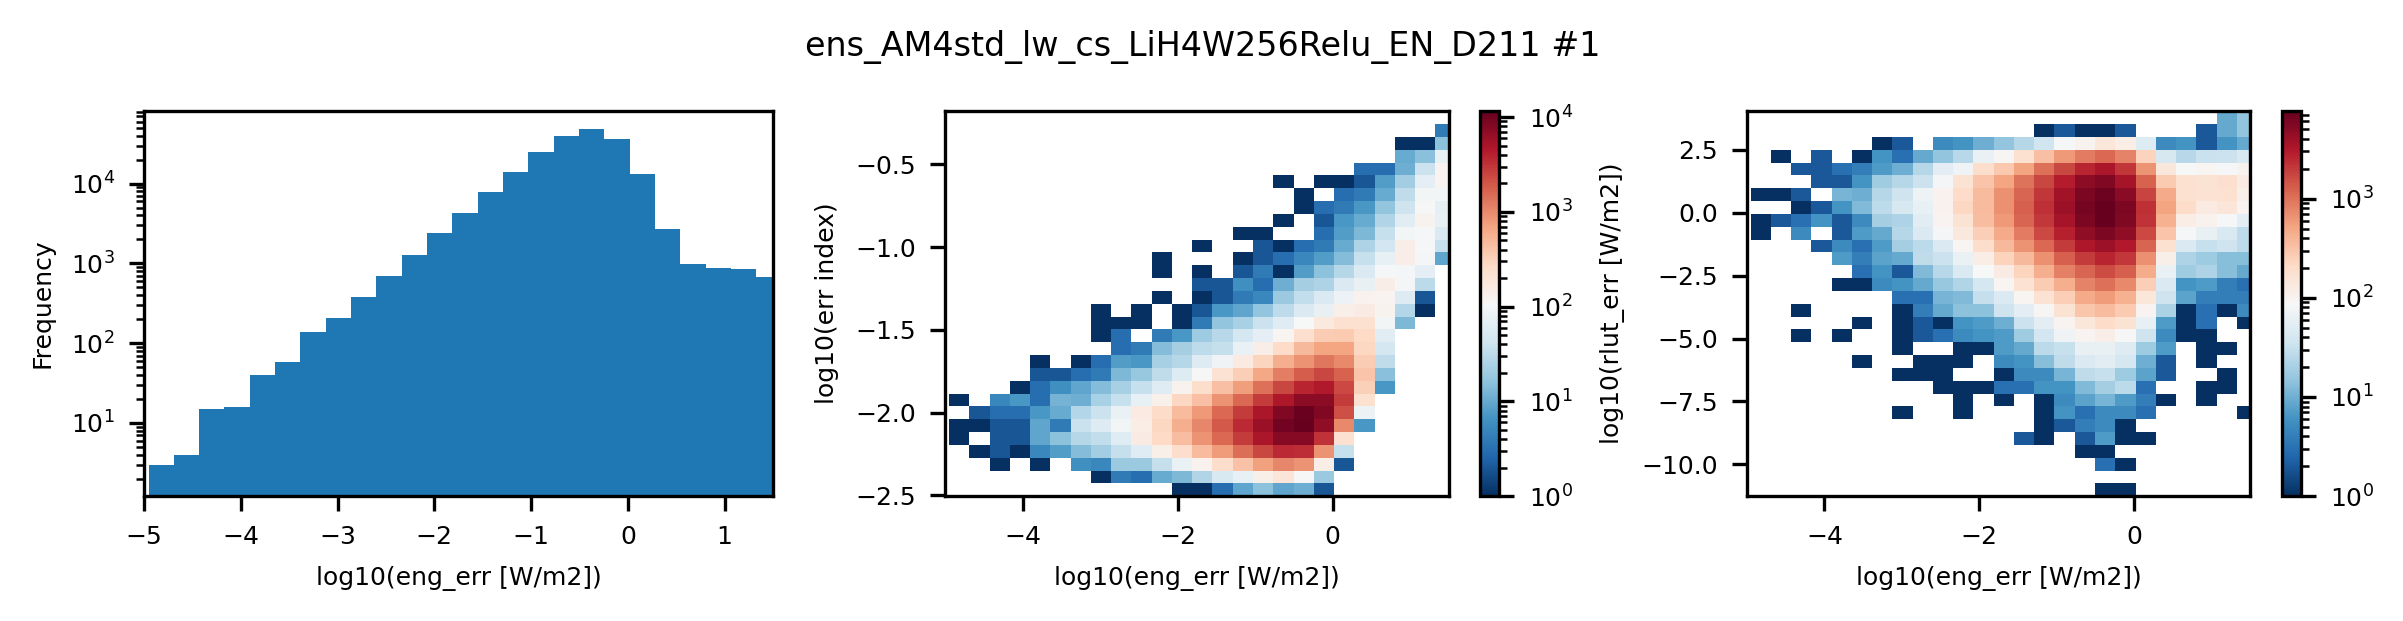

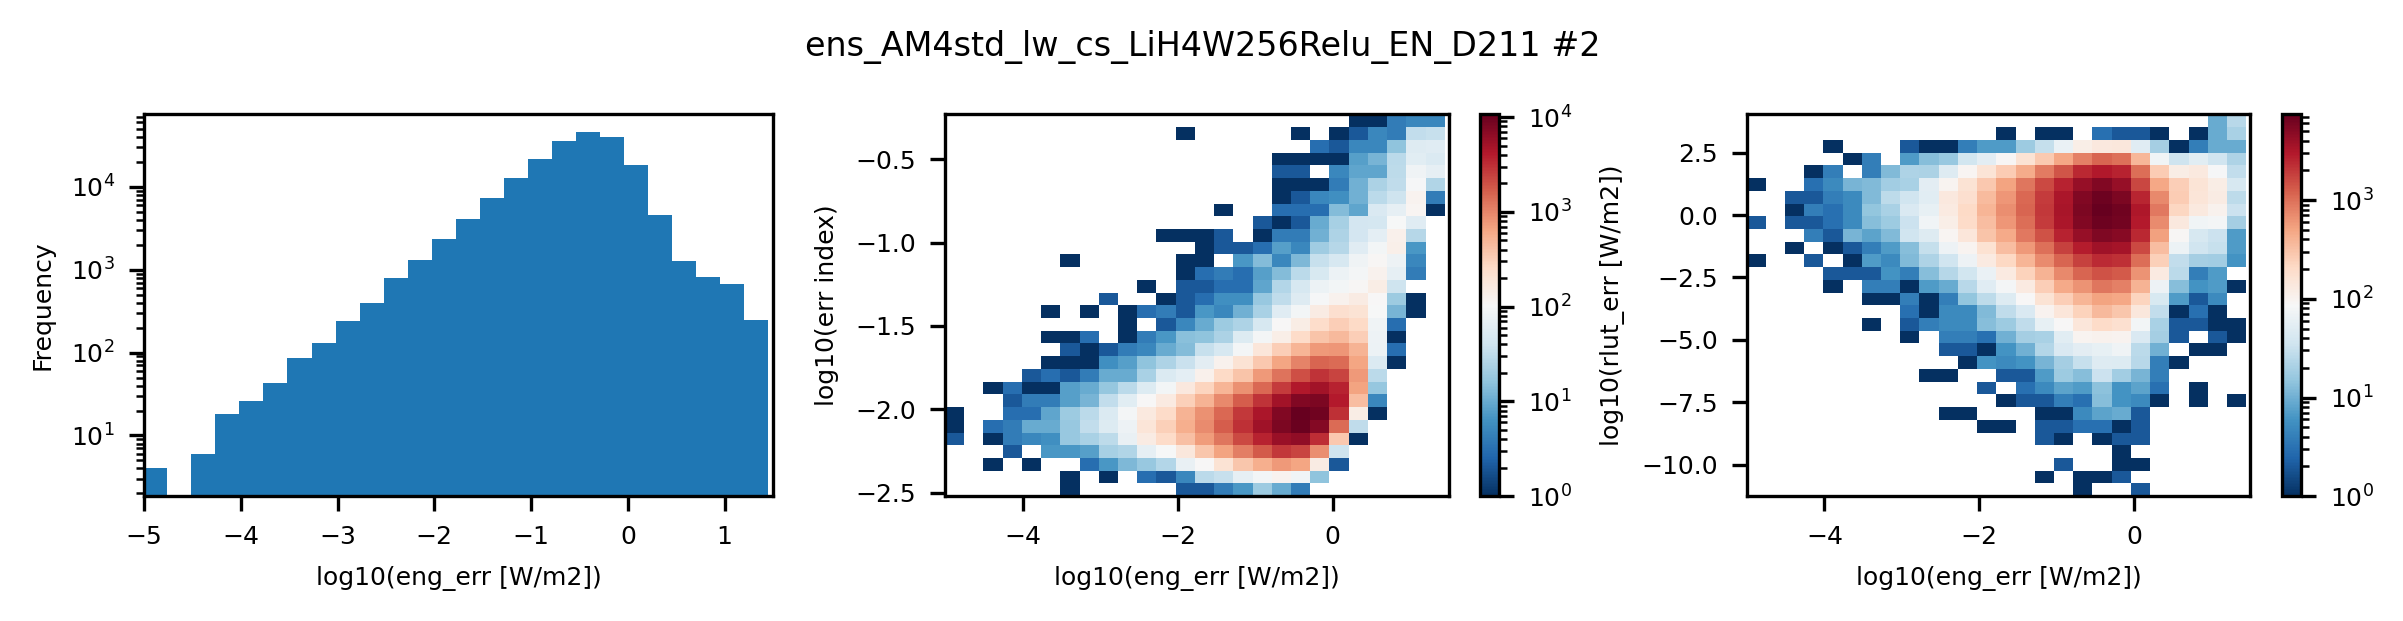

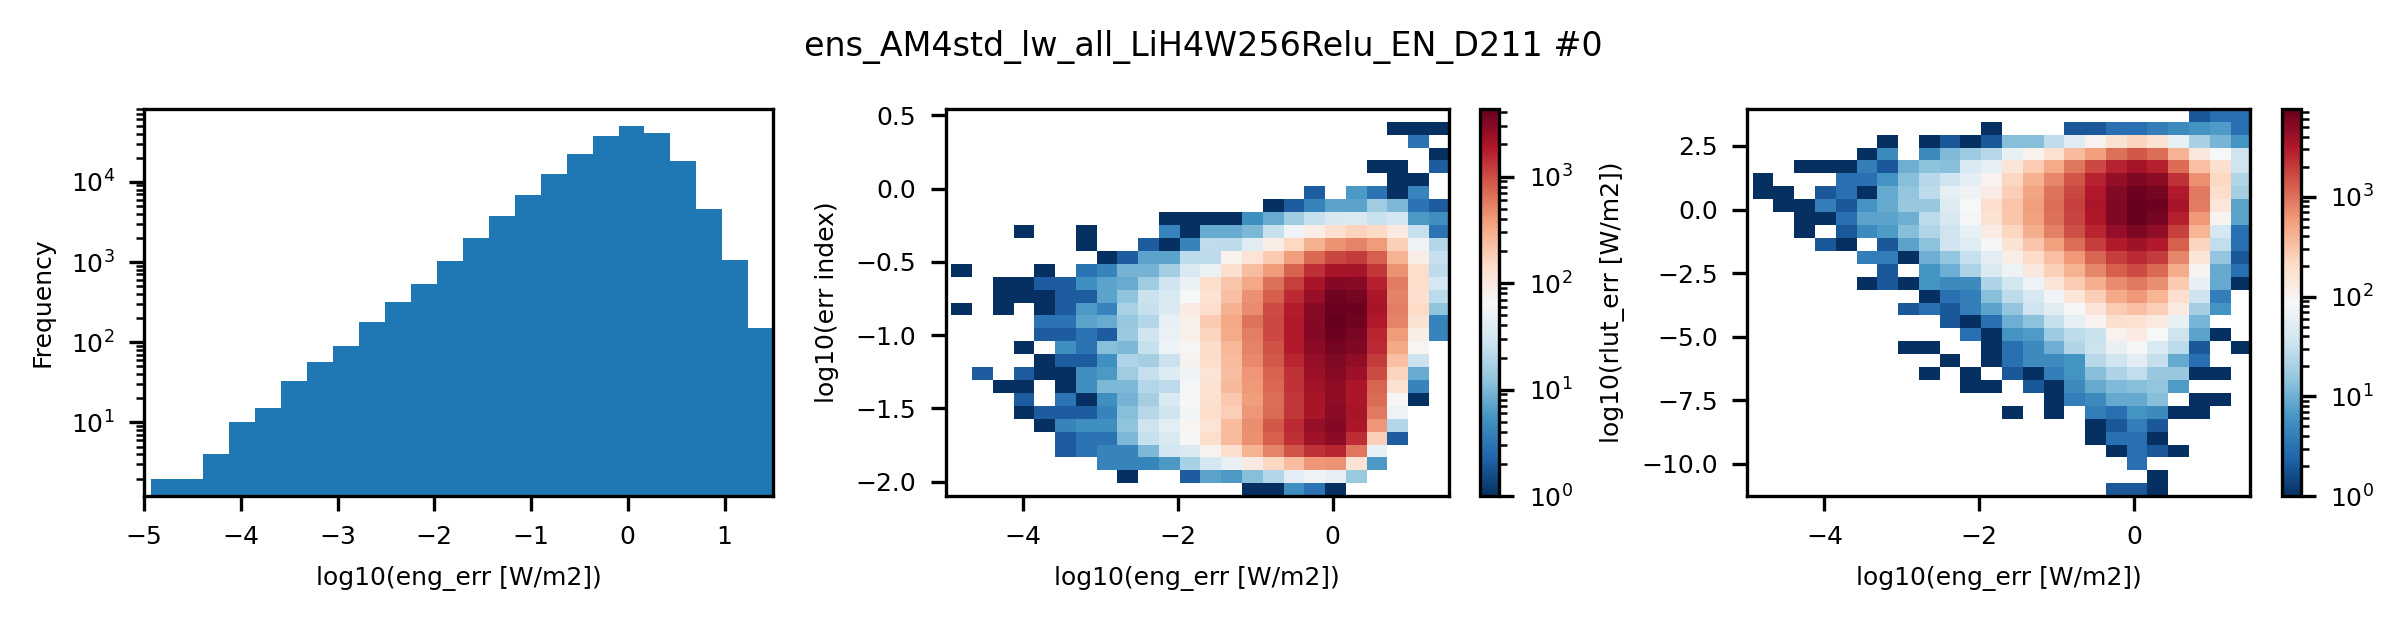

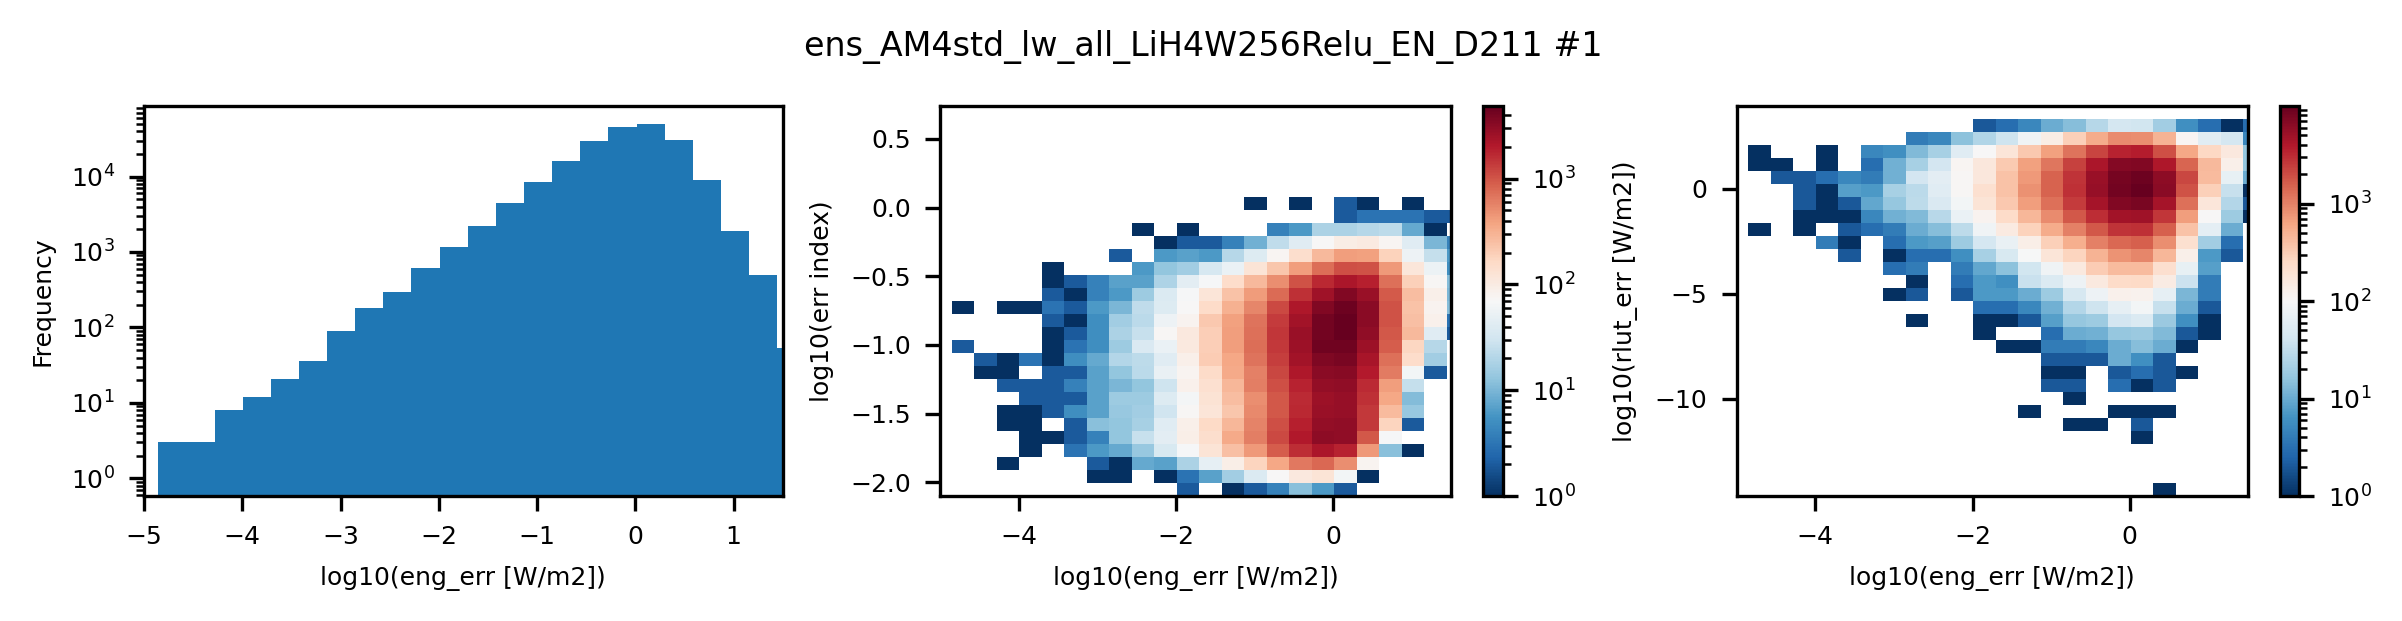

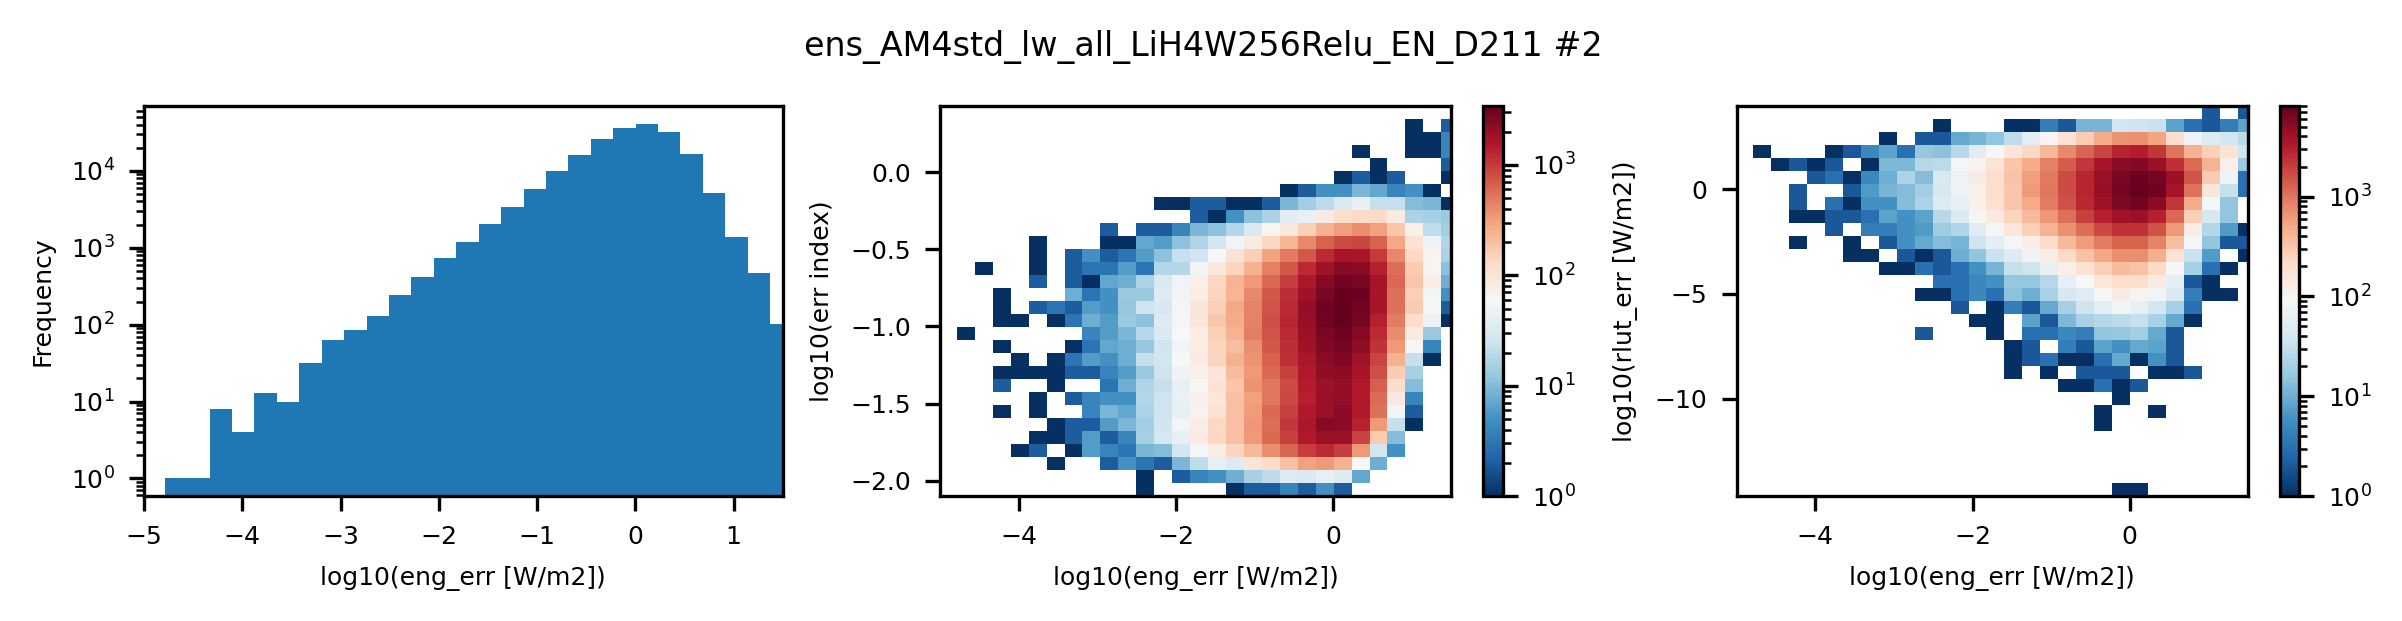

In [19]:
for i, mo in enumerate(Exp_name):  
    for ei in range(ensemble_size):
        err_eng_arr = err_vars_gn[mo][ei]['err_eng']  

        std_nor = std_nor_vars_gn[mo][ei]
        err_var_all = np.concatenate([np.atleast_2d(err_vars_gn[mo][ei][var].T)  for var in err_vars_name[1:]],axis=0)
        pred_err_ind = abs(err_var_all/std_nor[:,None]).mean(axis=0)
        
        rd_id_more = np.random.randint(0,err_eng_arr.size,200000)
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,2),dpi=300, tight_layout=True) 
        axs= axs.flatten()
        ax = axs[0]
        eng_err_log = np.log(abs(err_eng_arr[rd_id_more])+1e-6)/np.log(10)
        pred_err_ind_log = np.log(abs(pred_err_ind[rd_id_more])+1e-6)/np.log(10)
        ax.hist(eng_err_log,bins=30)
        ax.set_yscale('log')
        ax.set_xlim([-5,1.5])
        ax.set_xlabel('log10(eng_err [W/m2])')
        ax.set_ylabel('Frequency')
        ax = axs[1]
        h=ax.hist2d(eng_err_log,pred_err_ind_log, bins=30,
                    norm=colors.LogNorm(),
                    cmap='RdBu_r') 
        fig.colorbar(h[3], ax=ax)
        ax.set_xlim([-5,1.5])
        ax.set_xlabel('log10(eng_err [W/m2])')
        ax.set_ylabel('log10(err index)')
        ax = axs[2]
        h=ax.hist2d(eng_err_log,np.log(abs(err_var_arr[0,rd_id_more]+1e-6)/np.log(10)),
                   bins=30, 
                    norm=colors.LogNorm(),
                    cmap='RdBu_r') 
        fig.colorbar(h[3], ax=ax)
        ax.set_xlim([-5,1.5])
        ax.set_xlabel('log10(eng_err [W/m2])')
        ax.set_ylabel('log10(rlut_err [W/m2])')
        plt.suptitle(f'{mo} #{ei}',fontsize=8) 
        fig.show()